In [1]:
# prepare_data_for_eda.py scrip, without saving out to pkl or csv
import os
import pandas as pd
import logging.config
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler #for matplotlib colors
import seaborn as sns
from sklearn import preprocessing
from sqlalchemy import create_engine
import importlib
import missingno as msno
import functions_to_derive_vars
importlib.reload(functions_to_derive_vars)

LOGGING_CONFIG = os.getenv('LOGGING_CONFIG')
logging.config.fileConfig(LOGGING_CONFIG)
logger = logging.getLogger('prepare_data_for_eda')

DATADIR = os.getenv('DATADIR')
ENGINE = os.getenv('ENGINE')
logger.info("using data from {}".format(ENGINE))

2018-05-23 14:46:59,310 - prepare_data_for_eda - INFO - using data from postgresql://ellieking@localhost:5432/givedata_180515


In [ ]:
# ### Read in data
engine = create_engine(ENGINE)

logger.info('Importing facts_metrics')
facts_metrics = pd.read_sql_query('select * from "facts_metrics"',con=engine)

logger.info('Importing dates')
dates = pd.read_sql_query('select * from "dimensions_dates"',con=engine)
logger.info('Dropping {} dates duplicates'.format(sum(dates.duplicated())))
dates = dates.drop_duplicates()
logger.info('Importing items')
items = pd.read_sql_query('select * from "dimensions_items"',con=engine)
logger.info('Finished importing items')

2018-05-23 14:46:59,419 - prepare_data_for_eda - INFO - Importing facts_metrics
2018-05-23 14:50:58,042 - prepare_data_for_eda - INFO - Importing dates
2018-05-23 14:50:58,084 - prepare_data_for_eda - INFO - Dropping 0 dates duplicates
2018-05-23 14:50:58,092 - prepare_data_for_eda - INFO - Importing items


In [ ]:
logger.info("create lists of component variables")
spelling_grammar_vars = ['contractions_count',
                         'indefinite_article_count',
                         'redundant_acronyms_count',
                         'repeated_words_count',
                         'spell_count'
                         ]

style_vars = ['readability_score',
              'equality_count',
              'passive_count',
              'simplify_count'
              ]

error_vars = ['profanities_count', 'spell_count']

In [ ]:
facts_metrics_reduced = facts_metrics[['dimensions_date_id', 'dimensions_item_id', 'pageviews', 'unique_pageviews', 'feedex_comments',
       'is_this_useful_yes', 'is_this_useful_no',
       'number_of_internal_searches']].copy()

In [ ]:
# ### Join facts_metrics to specific item variables

logger.info("joining facts_metrics to items")

content_performance_bytime = pd.merge(
    left=facts_metrics_reduced,
    right=items,
    left_on='dimensions_item_id', #
    right_on='id', # 
    how='outer', # keep everything for checking merge
    indicator=True # so we can filter by match type
)

logger.info("{} items(right) matches in facts_metrics(left)".format(
    content_performance_bytime.groupby('_merge').size()
    )
)


# ### Dates to index for plots
logger.info("dates to index")
content_performance_bytime['date'] = pd.to_datetime(content_performance_bytime['dimensions_date_id'])
content_performance_bytime.index = content_performance_bytime['date']

In [ ]:
content_performance_bytime = functions_to_derive_vars.derive_variables(content_performance_bytime, spelling_grammar_vars, style_vars, error_vars, logger)

In [ ]:
metrics_time_independent = facts_metrics.groupby('dimensions_item_id').sum()
metrics_time_independent = metrics_time_independent.drop(['id'], axis=1)

In [ ]:
logger.info("joining metrics_time_independent to items")

content_performance = pd.merge(
    left=metrics_time_independent,
    right=items,
    left_index=True, # dimensions_items_id
    right_on='id', # database specific key
    how='outer', # keep everything for checking merge
    indicator=True # so we can filter by match type
)

logger.info("{} items(right) matches in metrics_time_independent(left)".format(
    content_performance.groupby('_merge').size()
    )
)
logger.info("content_performance.content_id.nunique()={}".format(content_performance.content_id.nunique()))
logger.info("content_performance.id.nunique()={}".format(content_performance.id.nunique()))
logger.info("content_performance.shape={}".format(content_performance.shape))

For each content item, there may be multiple ids because each time an item is edited it receives a new ID

In [ ]:
content_performance = functions_to_derive_vars.derive_variables(content_performance, spelling_grammar_vars, style_vars, error_vars, logger)

In [ ]:
del items, facts_metrics

# MISSING DATA FROM MISMATCHES

### Remove editions with no data

In [ ]:
content_performance = content_performance[content_performance['_merge']=='both'].copy()

In [ ]:
content_performance_bytime = content_performance_bytime[content_performance_bytime['_merge']=='both'].copy()

In [ ]:
logger.info("joining metrics_time_independent to items")
content_performance.to_sql('content_performance', engine)
logger.info("joining metrics_time_independent to items")

### duplicates?

In [13]:
content_performance_reduced = content_performance[['pageviews', 'unique_pageviews', 'feedex_comments',
       'is_this_useful_yes', 
       'number_of_internal_searches', 'id', 'content_id', 'title', 'base_path',
       'description', 'created_at', 'updated_at', 'latest', 
       'number_of_pdfs', 'document_type', 'content_purpose_document_supertype',
       'first_published_at', 'public_updated_at', 'number_of_word_files',
       'status', 'readability_score', 'contractions_count', 'equality_count',
       'indefinite_article_count', 'passive_count', 'profanities_count',
       'redundant_acronyms_count', 'repeated_words_count', 'simplify_count',
       'spell_count', 'string_length', 'sentence_count', 'word_count',
       'primary_organisation_title', 'locale',
       'count_survey_responses',
       'response_per_pageview', 'response_per_unique_pageview',
       'useful_per_responses', 'total_to_unique_pageviews',
       'feedex_per_unique_1000', 'searches_per_pageview_1000', 'spelling_grammar', 'style', 'errors']].copy()

In [14]:
content_performance_reduced.duplicated().sum()

0

In [15]:
content_performance_bytime_reduced = content_performance_bytime[['dimensions_date_id', 'dimensions_item_id', 'pageviews',
       'unique_pageviews', 'feedex_comments', 'is_this_useful_yes',
       'is_this_useful_no', 'number_of_internal_searches', 'id', 'content_id',
       'title', 'base_path', 'description', 'created_at', 'updated_at',
       'latest', 'number_of_pdfs', 'document_type',
       'content_purpose_document_supertype', 'first_published_at',
       'public_updated_at', 'number_of_word_files', 'status',
       'readability_score', 'contractions_count', 'equality_count',
       'indefinite_article_count', 'passive_count', 'profanities_count',
       'redundant_acronyms_count', 'repeated_words_count', 'simplify_count',
       'spell_count', 'string_length', 'sentence_count', 'word_count',
       'primary_organisation_title', 'primary_organisation_content_id',
       'primary_organisation_withdrawn', 'content_hash', 'locale',
       'publishing_api_payload_version','count_survey_responses',
       'response_per_pageview', 'response_per_unique_pageview',
       'useful_per_responses', 'total_to_unique_pageviews',
       'feedex_per_unique_1000', 'searches_per_pageview_1000', 'spelling_grammar', 'style', 'errors'
       ]].copy()

In [16]:
content_performance_bytime_reduced.duplicated().sum()

418662

In [17]:
content_performance_bytime = content_performance_bytime_reduced.drop_duplicates().copy()

In [18]:
content_performance_bytime.shape

(12983662, 52)

In [19]:
del content_performance_bytime_reduced

### Explore missing

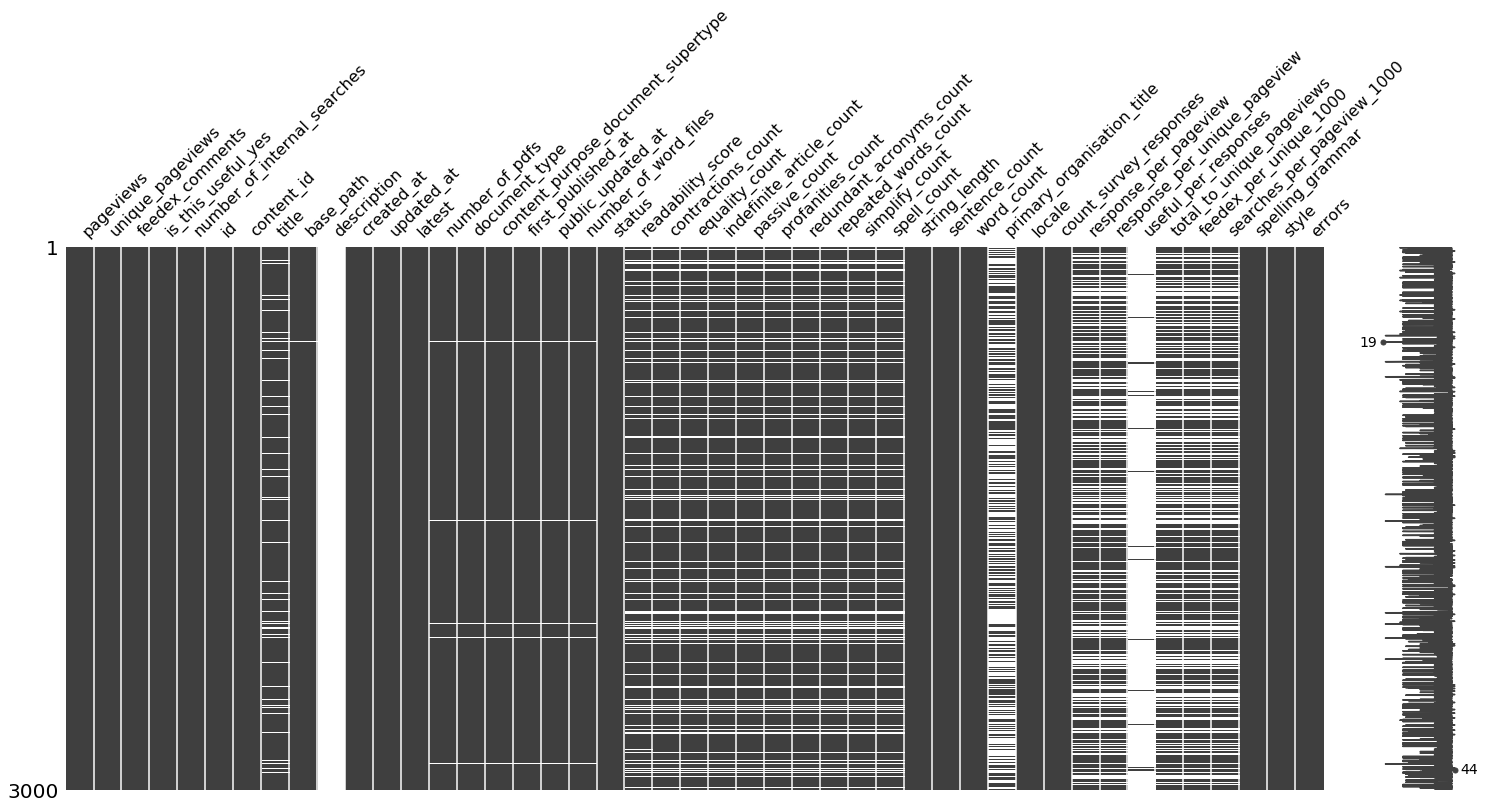

In [20]:
msno.matrix(content_performance_reduced.sample(3000))

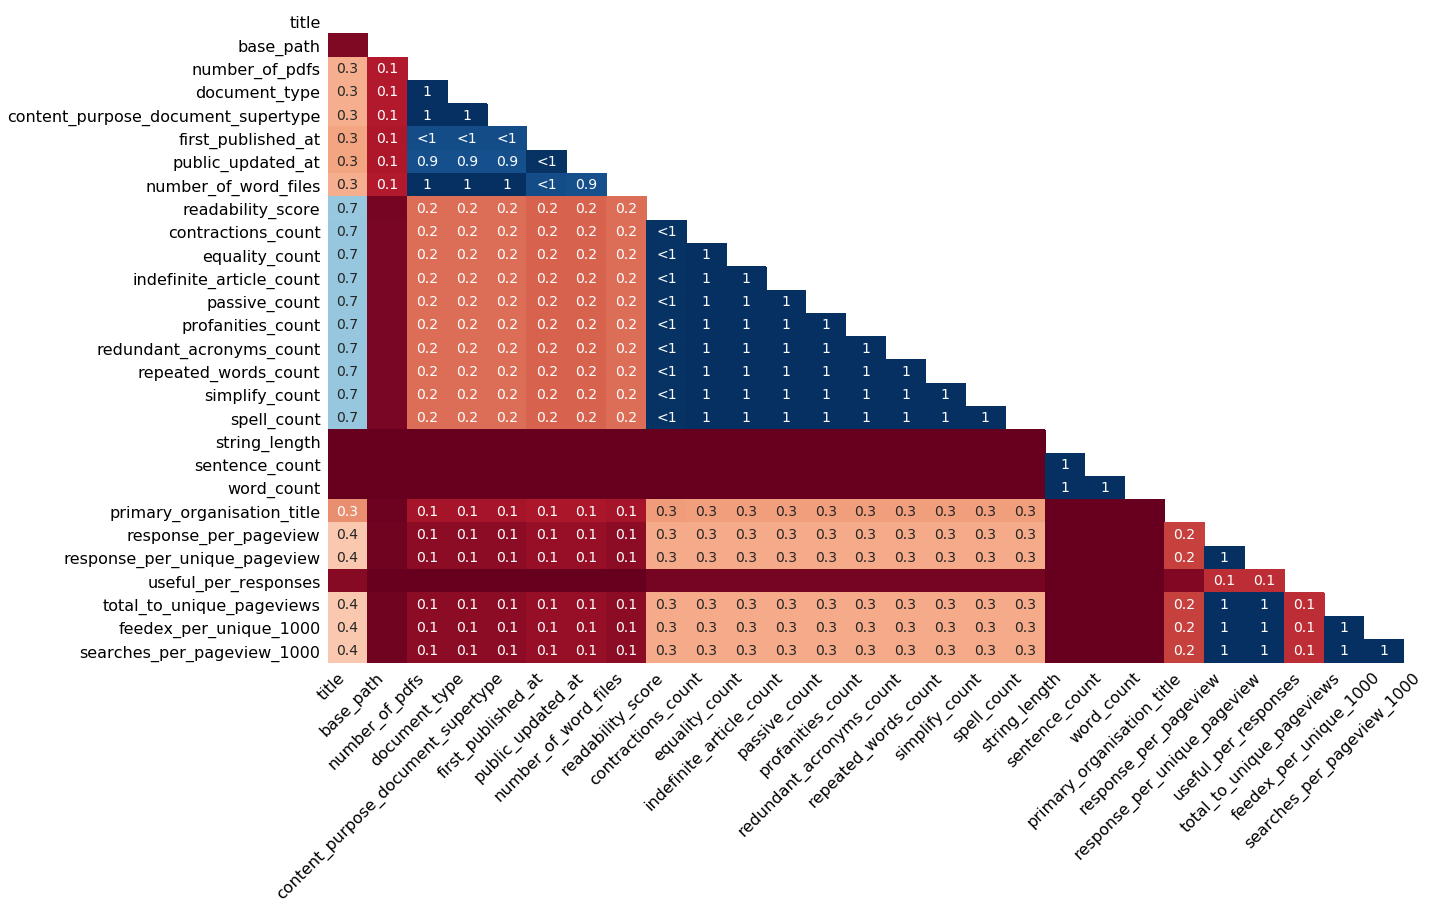

In [21]:
msno.heatmap(content_performance_reduced)

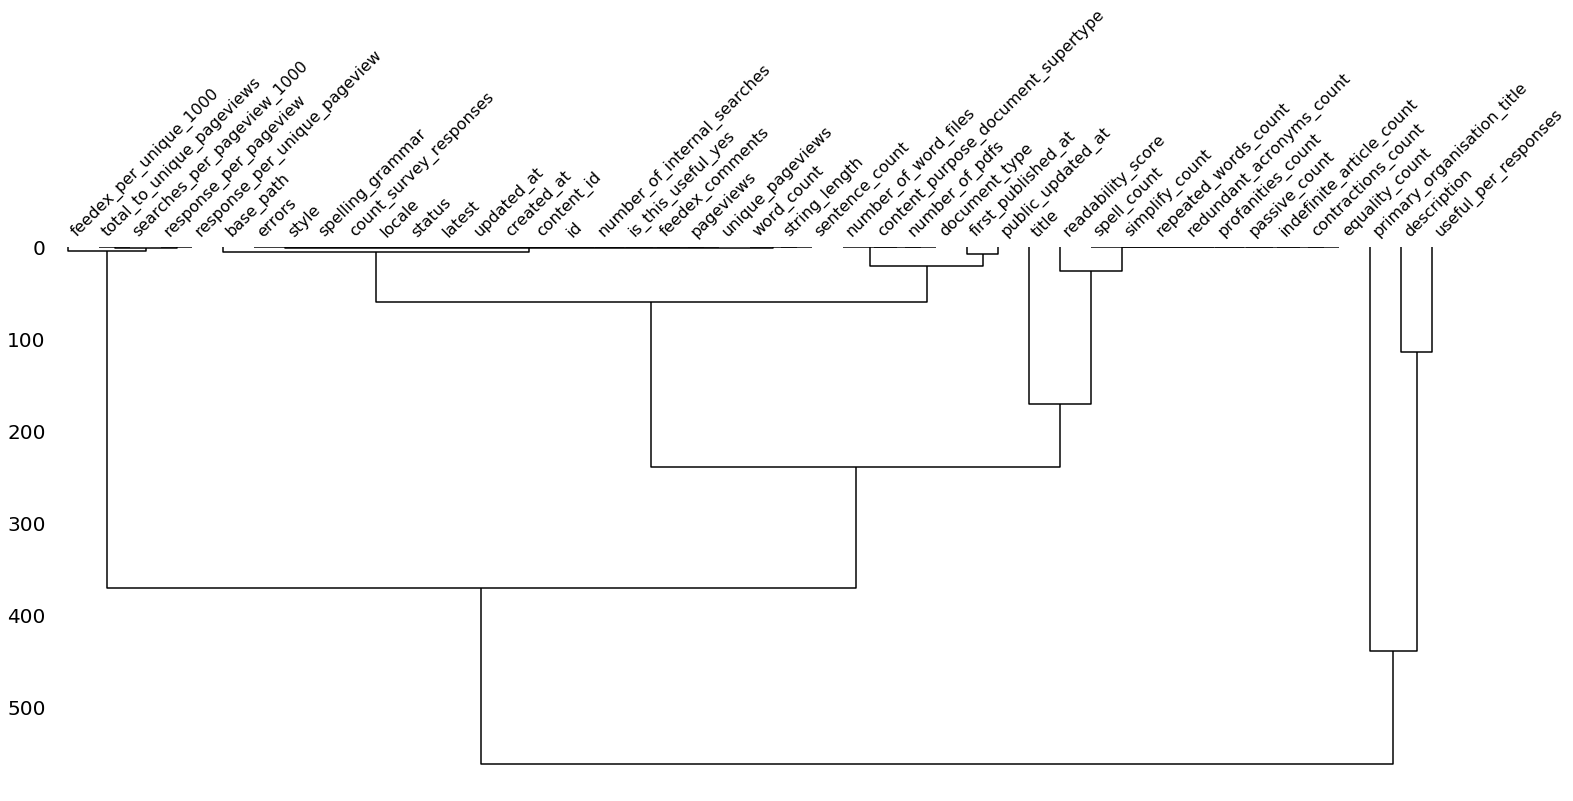

In [22]:
msno.dendrogram(content_performance_reduced)

In [23]:
# msno.matrix(content_performance_bytime.sample(1000), freq='D')

# Exploratory data analyses
1. Date of metric by fact, by document type/primary org (e.g., page views over date-dimension stratified by document type)
2. content-specific performance metric (e.g. reading age) by user-related performance metric (e.g., page views) over a defined time-period (min-max in date dimension)

### Dates to index for plots

In [24]:
content_performance_bytime.index

DatetimeIndex(['2018-04-02', '2018-04-03', '2018-04-04', '2018-04-05',
               '2018-04-21', '2018-04-06', '2018-04-07', '2018-04-08',
               '2018-04-09', '2018-04-14',
               ...
               '2018-05-01', '2018-05-02', '2018-05-01', '2018-05-02',
               '2018-05-01', '2018-05-02', '2018-05-01', '2018-05-02',
               '2018-05-01', '2018-05-02'],
              dtype='datetime64[ns]', name='date', length=12983662, freq=None)

# Intrinsic content performance metrics
Explore those metrics generated by characteristics of the content itself and their correlation with metrics relating to user interaction with content.

## Individual distributions

In [25]:
content_performance.columns

Index(['pageviews', 'unique_pageviews', 'feedex_comments',
       'is_this_useful_yes', 'is_this_useful_no',
       'number_of_internal_searches', 'id', 'content_id', 'title', 'base_path',
       'description', 'created_at', 'updated_at', 'latest', 'raw_json',
       'number_of_pdfs', 'document_type', 'content_purpose_document_supertype',
       'first_published_at', 'public_updated_at', 'number_of_word_files',
       'status', 'readability_score', 'contractions_count', 'equality_count',
       'indefinite_article_count', 'passive_count', 'profanities_count',
       'redundant_acronyms_count', 'repeated_words_count', 'simplify_count',
       'spell_count', 'string_length', 'sentence_count', 'word_count',
       'primary_organisation_title', 'primary_organisation_content_id',
       'primary_organisation_withdrawn', 'content_hash', 'locale',
       'publishing_api_payload_version', '_merge', 'count_survey_responses',
       'response_per_pageview', 'response_per_unique_pageview',
      

#### Content versions (could be multiple versions of a page) with survey responses

In [26]:
content_performance.content_id.nunique()

408754

In [27]:
content_performance.id.nunique()

420579

### Histograms

In [28]:
ga_vars = content_performance[['pageviews', 
                  'unique_pageviews', 
                  'feedex_comments', 
                  'is_this_useful_yes',
                               'is_this_useful_no',
                  'number_of_internal_searches', 
                  'count_survey_responses',
                  'response_per_pageview', 
                  'response_per_unique_pageview',
                  'useful_per_responses', 
                  'total_to_unique_pageviews',
                               'feedex_per_unique_1000'
                 ]].replace([np.inf, -np.inf], np.nan)
spell_grammar_vars = content_performance[[
                  'readability_score', 
                  'contractions_count', 
                  'equality_count',
                  'indefinite_article_count', 
                  'passive_count', 
                  'profanities_count',
                  'redundant_acronyms_count', 
                  'repeated_words_count', 
                  'simplify_count',
                  'spell_count',  
                 ]].replace([np.inf, -np.inf], np.nan)
content_vars = content_performance[[ 
                  'number_of_pdfs', 
                  'number_of_word_files',
                  'string_length', 
                  'sentence_count', 
                  'word_count'
                 ]].replace([np.inf, -np.inf], np.nan)

all_content_vars = content_performance[[ 'pageviews', 
                                        'unique_pageviews', 
                                        'feedex_comments',
                                        'is_this_useful_yes', 
                                        'is_this_useful_no',
                                        'number_of_internal_searches', 
                                        'number_of_pdfs', 
                                        'document_type', 
                                        'content_purpose_document_supertype',
                                        'first_published_at', 
                                        'public_updated_at', 
                                        'number_of_word_files',
                                        'status',                                          
                                        'string_length', 
                                        'sentence_count', 
                                        'word_count',
                                        'primary_organisation_content_id',
                                        'locale',
                                        'publishing_api_payload_version', 
                                        'count_survey_responses',
                                        'response_per_pageview', 
                                        'response_per_unique_pageview',
                                        'useful_per_responses', 
                                        'total_to_unique_pageviews',
                                        'feedex_per_unique_1000', 
                                        'searches_per_pageview_1000',
                                        'contractions_count_scaled', 
                                        'indefinite_article_count_scaled',
                                        'redundant_acronyms_count_scaled', 
                                        'repeated_words_count_scaled',
                                        'spell_count_scaled', 
                                        'readability_score_scaled',
                                        'equality_count_scaled', 
                                        'passive_count_scaled',
                                        'simplify_count_scaled', 
                                        'profanities_count_scaled', 
                                        'spelling_grammar',
                                        'style', 
                                        'errors'
                                       ]].replace([np.inf, -np.inf], np.nan)

composite_vars = content_performance[['spelling_grammar',
                                        'style', 
                                        'errors'
                                       ]].replace([np.inf, -np.inf], np.nan)

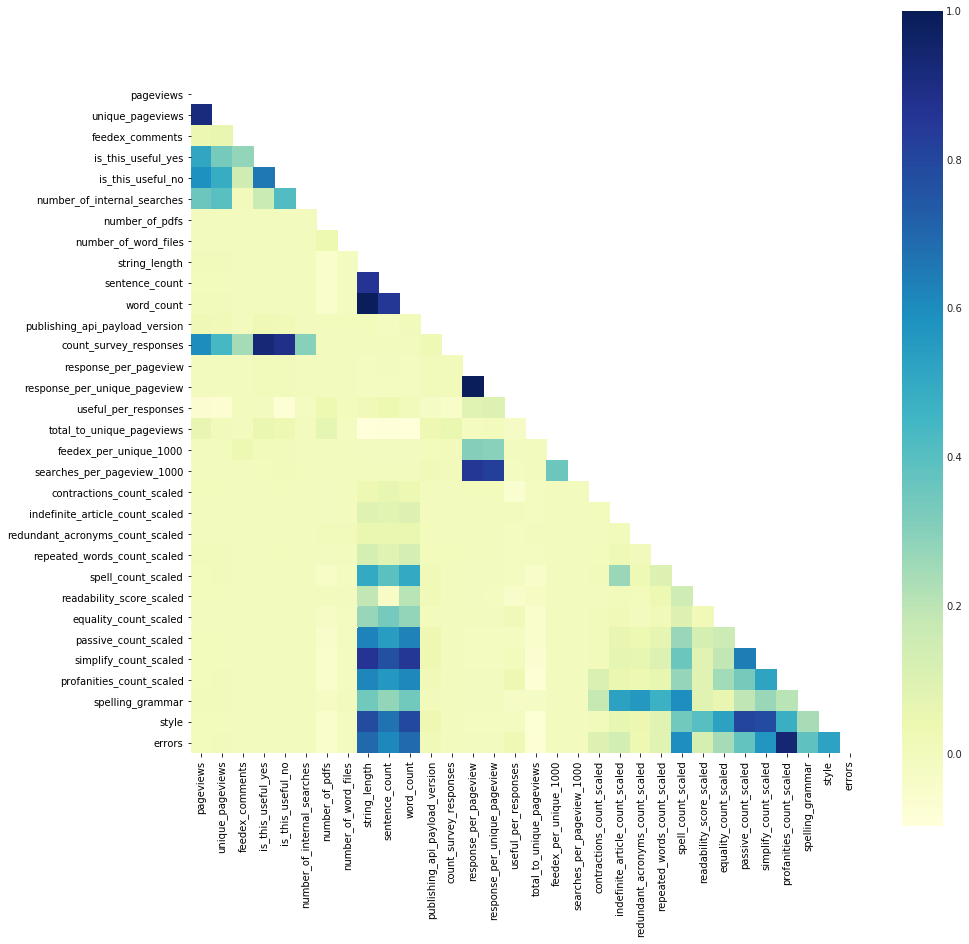

In [29]:
# calculate the correlation matrix
corr_all = all_content_vars.corr()

# # plot the heatmap
# sns.heatmap(corr, 
#         xticklabels=corr.columns,
#         yticklabels=corr.columns)
fig, ax = plt.subplots(figsize=(15, 15))
mask = np.zeros_like(corr_all)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr_all, mask=mask, square=True, cmap="YlGnBu")

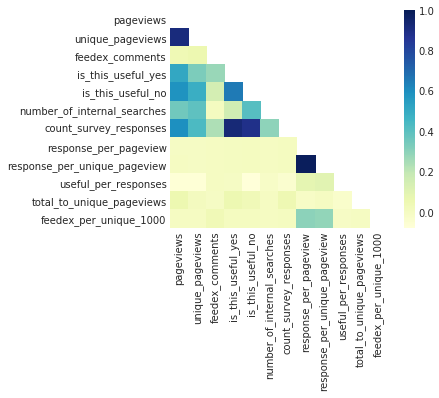

In [30]:
# calculate the correlation matrix
corr = ga_vars.corr()

# # plot the heatmap
# sns.heatmap(corr, 
#         xticklabels=corr.columns,
#         yticklabels=corr.columns)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=True, cmap="YlGnBu")

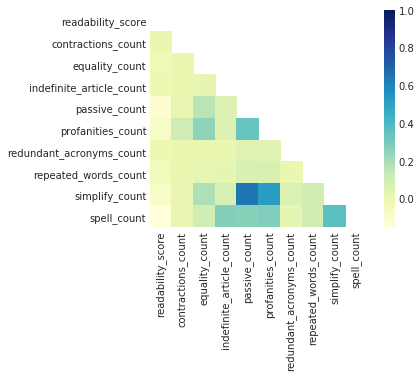

In [31]:
# calculate the correlation matrix
corr_sg = spell_grammar_vars.corr()

# # plot the heatmap
# sns.heatmap(corr_sg, 
#         xticklabels=corr_sg.columns,
#         yticklabels=corr_sg.columns)

mask = np.zeros_like(corr_sg)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr_sg, mask=mask, square=True, cmap="YlGnBu")

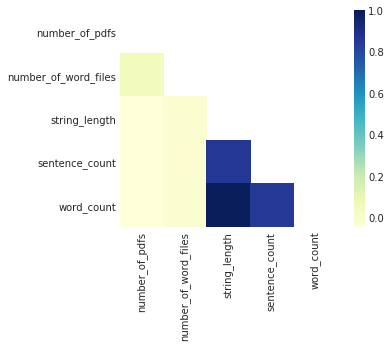

In [32]:
# calculate the correlation matrix
corr_content = content_vars.corr()

# # plot the heatmap
# sns.heatmap(corr_content, 
#         xticklabels=corr_content.columns,
#         yticklabels=corr_content.columns)

mask = np.zeros_like(corr_content)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr_content, mask=mask, square=True, cmap="YlGnBu")

### proportion zero

In [67]:
unscaled_content_vars = content_performance[[ 'pageviews', 
                                        'unique_pageviews', 
                                        'feedex_comments',
                                        'is_this_useful_yes', 
                                        'is_this_useful_no',
                                        'number_of_internal_searches', 
                                        'number_of_pdfs',                                 
                                        'number_of_word_files',                                        
                                        'string_length', 
                                        'sentence_count', 
                                        'word_count',
                                        'count_survey_responses',
                                        'response_per_pageview', 
                                        'response_per_unique_pageview',
                                        'useful_per_responses', 
                                        'total_to_unique_pageviews',
                                        'feedex_per_unique_1000', 
                                        'searches_per_pageview_1000',
                                        'contractions_count', 
                                        'indefinite_article_count',
                                        'redundant_acronyms_count', 
                                        'repeated_words_count',
                                        'spell_count', 
                                        'readability_score',
                                        'equality_count', 
                                        'passive_count',
                                        'simplify_count', 
                                        'profanities_count', 
                                        'spelling_grammar',
                                        'style', 
                                        'errors'
                                       ]].replace([np.inf, -np.inf], np.nan)

In [68]:
proportion_zero = unscaled_content_vars[unscaled_content_vars == 0].count(axis=0)/len(unscaled_content_vars.index)

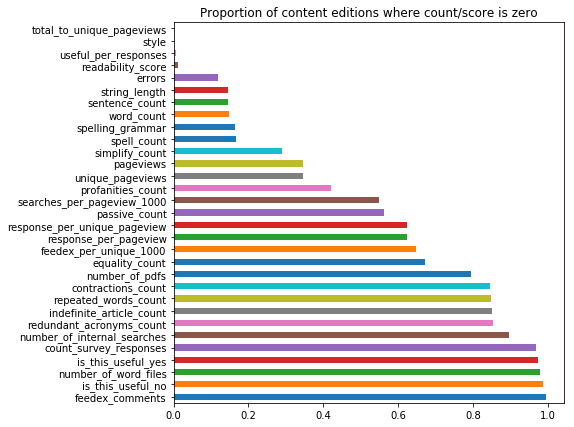

In [77]:
proportion_zero.sort_values(ascending=False).plot(kind = 'barh', figsize=(7, 7), title='Proportion of content editions where count/score is zero')

In [57]:
def proportion_zero(col):
    zero = len(col==0)
    prop = zero/len(col)
    return prop

In [58]:
unscaled_content_vars.apply(proportion_zero, axis=0)

399347    1.0
399349    1.0
399351    1.0
399353    1.0
399350    1.0
399355    1.0
399354    1.0
399352    1.0
399359    1.0
399356    1.0
399365    1.0
399370    1.0
399357    1.0
399371    1.0
399358    1.0
399383    1.0
399375    1.0
399360    1.0
399366    1.0
354506    1.0
399372    1.0
399376    1.0
399367    1.0
399373    1.0
399361    1.0
399380    1.0
399385    1.0
399388    1.0
354507    1.0
399377    1.0
         ... 
241904    1.0
242007    1.0
242019    1.0
242008    1.0
242009    1.0
242010    1.0
242020    1.0
242083    1.0
241944    1.0
242157    1.0
242124    1.0
235206    1.0
242025    1.0
235229    1.0
242058    1.0
241910    1.0
241181    1.0
242022    1.0
242057    1.0
242222    1.0
242062    1.0
242021    1.0
232804    1.0
242060    1.0
242023    1.0
242141    1.0
242061    1.0
242079    1.0
242059    1.0
242064    1.0
Length: 420579, dtype: float64

In [33]:
ga_vars.describe()

,pageviews,unique_pageviews,feedex_comments,is_this_useful_yes,is_this_useful_no,number_of_internal_searches,count_survey_responses,response_per_pageview,response_per_unique_pageview,useful_per_responses,total_to_unique_pageviews,feedex_per_unique_1000
count,4.205790e+05,4.205790e+05,420579.000000,420579.000000,420579.000000,4.205790e+05,420579.000000,275202.000000,275202.000000,13164.000000,275202.000000,275202.000000
mean,5.545781e+02,3.880235e+02,0.317370,0.465691,0.380471,7.805330e+00,0.846162,0.006813,0.007997,0.697774,1.268441,0.204085
std,2.144163e+04,1.497270e+04,119.526732,26.902771,21.316879,2.234185e+03,43.927664,0.175157,0.180676,0.405442,0.388523,12.563973
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.363636,1.000000,0.000000
50%,2.000000e+00,2.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,1.181818,0.000000
75%,1.800000e+01,1.400000e+01,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,1.375000,0.000000
max,4.035051e+06,2.910955e+06,76567.000000,10444.000000,7135.000000,1.270770e+06,13469.000000,78.333333,78.333333,1.000000,48.921260,3000.000000


In [34]:
ga_vars.pageviews.describe()

count    4.205790e+05
mean     5.545781e+02
std      2.144163e+04
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+00
75%      1.800000e+01
max      4.035051e+06
Name: pageviews, dtype: float64

In [35]:
np.log(18)

2.8903717578961645

In [36]:
np.exp(15)

3269017.3724721107

In [ ]:
ga_vars.hist(bins=100, figsize=(20, 30))

In [ ]:
composite_vars.hist(bins=100, figsize=(10, 10))

In [ ]:
content_vars.hist(bins=100, figsize=(30, 30))

In [ ]:
spell_grammar_vars.hist(bins=100, figsize=(30, 30))

(array([-500000.,       0.,  500000., 1000000., 1500000., 2000000.,
        2500000., 3000000., 3500000., 4000000., 4500000.]),
 <a list of 11 Text xticklabel objects>)

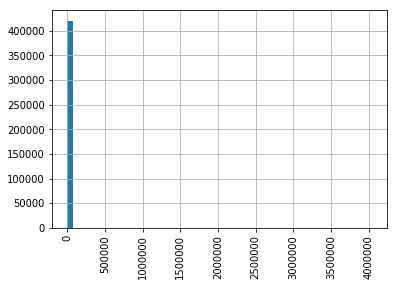

In [41]:
ga_vars['pageviews'].hist(bins=50)
plt.xticks(rotation=90)

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 8 Text xticklabel objects>)

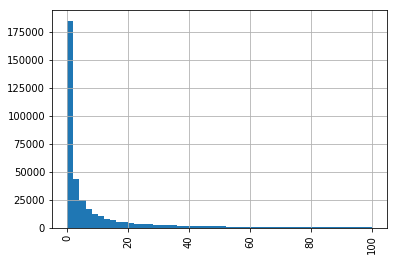

In [42]:
ga_vars['pageviews'].hist(bins=50, range=(0, 100))
plt.xticks(rotation=90)

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text xticklabel objects>)

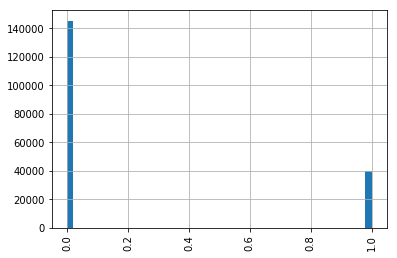

In [43]:
ga_vars['pageviews'].hist(bins=50, range=(0, 1))
plt.xticks(rotation=90)

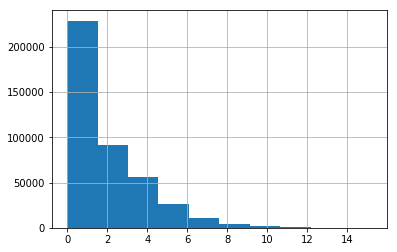

In [44]:
log_transformed = (ga_vars['pageviews']+1).apply(np.log)

log_transformed.hist()

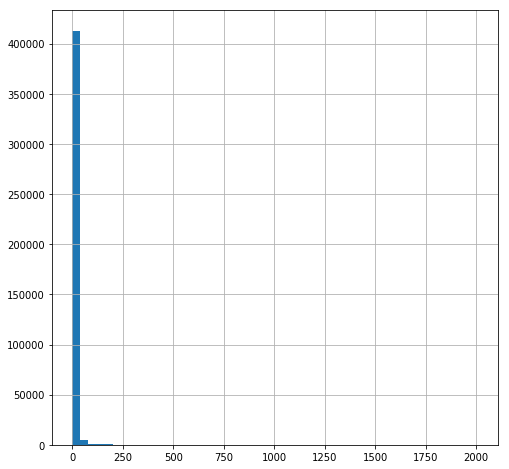

In [45]:

sqrt_transformed = ga_vars['pageviews'].apply(np.sqrt) # Get the square root of data points*

sqrt_transformed.hist(figsize=(8,8),     # Plot histogram
                 bins=50)

In [46]:
#    'status',  'document_type', 'content_purpose_document_supertype',
#        'first_published_at', 'public_updated_at', 'primary_organisation_title', 
#                   'locale',

In [47]:
content_performance[content_performance['count_survey_responses']>0].shape

(13164, 62)

In [48]:
content_performance[content_performance['count_survey_responses']==0].shape

(407415, 62)

In [49]:
content_performance[content_performance['count_survey_responses']>0].shape[0] + content_performance[content_performance['count_survey_responses']==0].shape[0]

420579

In [50]:
content_performance[content_performance['count_survey_responses'].isnull()].shape[0] + \
content_performance[content_performance['count_survey_responses']>0].shape[0] + \
content_performance[content_performance['count_survey_responses']==0].shape[0]

420579

In [51]:
print("{} out of {} ({}%) versions of pages have at least 1 survey response".format(
    content_performance[content_performance['count_survey_responses']>0].shape[0], 
    content_performance.id.nunique(), 
    content_performance[content_performance['count_survey_responses']>0].shape[0]/ 
    content_performance.id.nunique()*100
                                                                                   ))

13164 out of 420579 (3.1299708259328214%) versions of pages have at least 1 survey response


#### Useful_per_response

In [52]:
content_performance.useful_per_responses.describe()

count    13164.000000
mean         0.697774
std          0.405442
min          0.000000
25%          0.363636
50%          1.000000
75%          1.000000
max          1.000000
Name: useful_per_responses, dtype: float64

Text(0.5,1,'Proportion of respondents who found edition useful')

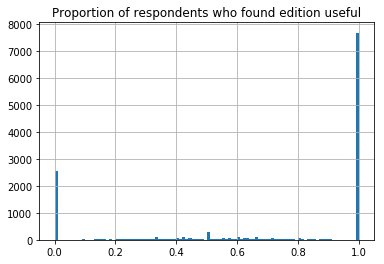

In [73]:
content_performance.useful_per_responses.hist(bins=100, range=(0, 1))
plt.title('Proportion of respondents who found edition useful')

#### responses_per_pageview

In [80]:
content_performance = content_performance.replace([np.inf, -np.inf], np.nan).copy()

In [81]:
content_performance.response_per_pageview.describe()

count    275202.000000
mean          0.006813
std           0.175157
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          78.333333
Name: response_per_pageview, dtype: float64

In [82]:
content_performance[content_performance['response_per_unique_pageview']>4]

,pageviews,unique_pageviews,feedex_comments,is_this_useful_yes,is_this_useful_no,number_of_internal_searches,id,content_id,title,base_path,...,repeated_words_count_scaled,spell_count_scaled,readability_score_scaled,equality_count_scaled,passive_count_scaled,simplify_count_scaled,profanities_count_scaled,spelling_grammar,style,errors
39508,1.0,1.0,0.0,5.0,0.0,0.0,3717654,5e96a6eb-7631-11e4-a3cb-005056011aef,MHRA business engagement assessment on introdu...,/government/consultations/mhra-business-engage...,...,0.000000,0.000402,0.010731,0.000000,0.004762,0.000000,0.000000,0.000402,0.015493,0.000402
298974,1.0,1.0,0.0,0.0,5.0,0.0,3777373,5dc21336-7631-11e4-a3cb-005056011aef,"CDO Update, Autumn 2011",/government/publications/cdo-update-autumn-2011,...,0.000000,0.000000,0.010390,0.000000,0.000000,0.000991,0.000000,0.000000,0.011381,0.000000
301354,1.0,1.0,0.0,0.0,5.0,0.0,3782432,5e2b92ef-7631-11e4-a3cb-005056011aef,Family Resources Survey: description of non-re...,/government/statistics/family-resources-survey...,...,0.000000,0.000201,0.009113,0.000000,0.000000,0.002973,0.000000,0.000201,0.012086,0.000201
226837,1.0,1.0,0.0,0.0,5.0,0.0,3936291,5c87ba97-7631-11e4-a3cb-005056011aef,The importance of UK relations with Indonesia,/government/news/the-importance-of-uk-relation...,...,0.000000,0.000101,0.008942,0.009631,0.000000,0.000000,0.001227,0.000101,0.018573,0.001328
242059,3.0,3.0,7.0,76.0,159.0,985.0,4061227,03531ffd-314b-4fed-9361-fa9816005c31,Driving and transport,/browse/driving,...,0.000259,0.001138,0.011268,0.001860,0.004398,0.004690,0.003659,0.001798,0.022215,0.004797


Can't yet explain why these items were only viewed once but have 5 survey responses. 
Concerning regarding the denominator!

Text(0.5,1,'proportion of repsondents who found page useful by pageviews')

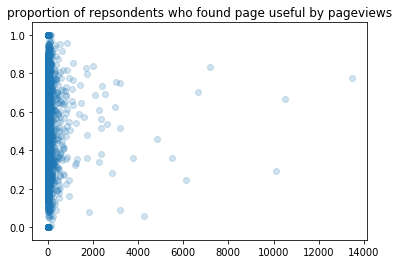

In [104]:
plt.scatter(content_performance.count_survey_responses,  content_performance.useful_per_responses, alpha=0.2)
plt.title("proportion of repsondents who found page useful by pageviews")

Text(0.5,1,'proportion of repsondents who found page useful by resonses')

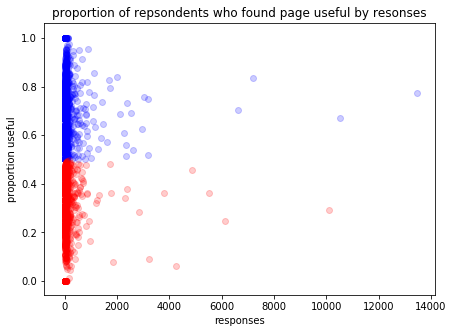

In [122]:
# normal values
plt.figure(figsize=(7, 5))
# plt.text(0, 0, "taxons with no content in dev set", color='red', horizontalalignment='center', 
#          verticalalignment='bottom')
plt.xlabel('responses')
plt.ylabel('proportion useful')
plt.scatter(content_performance.count_survey_responses[content_performance['useful_per_responses']>=0.5],  
                                                       content_performance.useful_per_responses[content_performance['useful_per_responses']>=0.5], 
                                                                                                c = 'b',
                                                                                                alpha=0.2, 
                                                                                                )
# less than 0.8
plt.scatter(content_performance.count_survey_responses[content_performance['useful_per_responses']<0.5 ],  
                                                       content_performance.useful_per_responses[content_performance['useful_per_responses']<0.5], 
                                                                                                c = 'red',
                                                                                                alpha=0.2, 
                                                                                                )


plt.title("proportion of repsondents who found page useful by resonses")

# for label, x, y in zip(dev_metrics['taxon2label'], dev_metrics['support'], dev_metrics['f1']):
#     if ((x>300 and y<0.8) or (x>1000)):
#         plt.annotate(
#             label,
#             xy=(x, y), xytext=(-1, 1),
#             textcoords='offset points', ha='right', va='bottom')
#     if (y==1):
#         label = ""
#         plt.annotate(
#             label,
#             xy=(x, y), xytext=(-1, 1),
#             textcoords='offset points', ha='right', va='bottom')

(array([-1000000.,        0.,  1000000.,  2000000.,  3000000.,  4000000.,
         5000000.]), <a list of 7 Text xticklabel objects>)

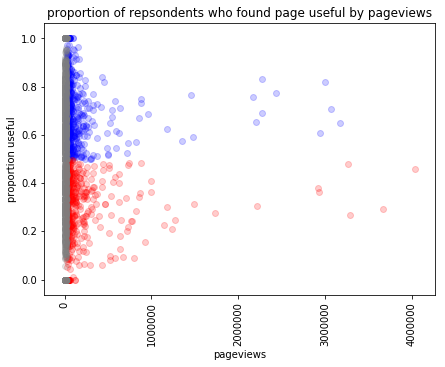

In [134]:
# normal values
plt.figure(figsize=(7, 5))
# plt.text(0, 0, "taxons with no content in dev set", color='red', horizontalalignment='center', 
#          verticalalignment='bottom')
plt.xlabel('pageviews')
plt.ylabel('proportion useful')
plt.scatter(content_performance.pageviews[(content_performance['useful_per_responses']>=0.5) & (content_performance['pageviews']>20000)],  
                                                       content_performance.useful_per_responses[(content_performance['useful_per_responses']>=0.5)  & (content_performance['pageviews']>20000)], 
                                                                                                c = 'b',
                                                                                                alpha=0.2, 
                                                                                                )
# less than 0.8
plt.scatter(content_performance.pageviews[(content_performance['useful_per_responses']<0.5 ) & (content_performance['pageviews']>20000)],  
                                                       content_performance.useful_per_responses[(content_performance['useful_per_responses']<0.5) & (content_performance['pageviews']>20000)], 
                                                                                                c = 'red',
                                                                                                alpha=0.2, 
                                                                                                )

# 0
plt.scatter(content_performance.pageviews[content_performance['pageviews']<=20000 ],  
                                                       content_performance.useful_per_responses[content_performance['pageviews']<=20000], 
                                                                                                c = 'grey',
                                                                                                alpha=0.2, 
                                                                                                )


plt.title("proportion of repsondents who found page useful by pageviews")

plt.xticks(rotation=90)

# for label, x, y in zip(dev_metrics['taxon2label'], dev_metrics['support'], dev_metrics['f1']):
#     if ((x>300 and y<0.8) or (x>1000)):
#         plt.annotate(
#             label,
#             xy=(x, y), xytext=(-1, 1),
#             textcoords='offset points', ha='right', va='bottom')
#     if (y==1):
#         label = ""
#         plt.annotate(
#             label,
#             xy=(x, y), xytext=(-1, 1),
#             textcoords='offset points', ha='right', va='bottom')

(0, 100)

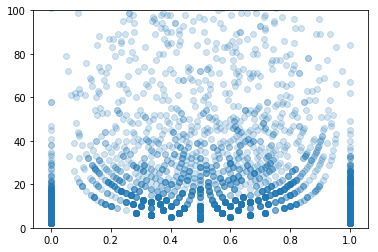

In [84]:
plt.scatter(content_performance.useful_per_responses, content_performance.count_survey_responses, alpha=0.2)
plt.ylim(0, 100)

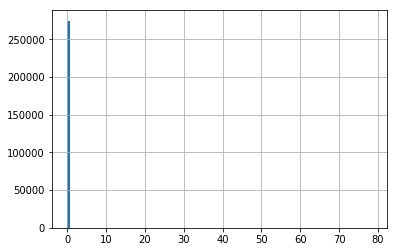

In [85]:
content_performance.response_per_pageview.hist(bins=100)

#### responses_unique_per_pageview

In [86]:
content_performance.response_per_unique_pageview.describe()

count    275202.000000
mean          0.007997
std           0.180676
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          78.333333
Name: response_per_unique_pageview, dtype: float64

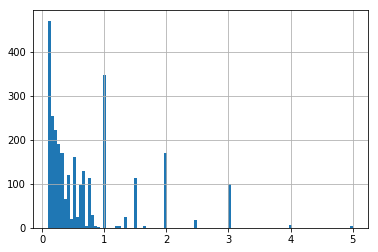

In [87]:
content_performance.response_per_unique_pageview.hist(bins=100, range=(0.1, 5))

#### string_length

In [88]:
content_performance.string_length.describe()

count    420578.000000
mean       1626.974183
std        3853.419194
min           0.000000
25%         107.000000
50%         533.000000
75%        1732.000000
max      101170.000000
Name: string_length, dtype: float64

#### string length

In [89]:
content_performance.string_length.describe()

count    420578.000000
mean       1626.974183
std        3853.419194
min           0.000000
25%         107.000000
50%         533.000000
75%        1732.000000
max      101170.000000
Name: string_length, dtype: float64

In [90]:
print('{} out of {} content items ({}%) have a recorded string_length of 0'.format(
    content_performance[content_performance['string_length']==0].shape[0], 
    content_performance.content_id.nunique(),
    round(content_performance[content_performance['string_length']==0].shape[0]/content_performance.content_id.nunique()*100, 2)))

61209 out of 408754 content items (14.97%) have a recorded string_length of 0


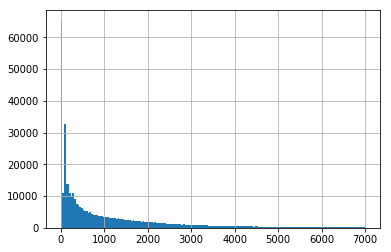

In [91]:
content_performance.string_length.hist(bins='auto', range=(0, 7000))

#### readability score
"Check readability"?!

In [92]:
content_performance.readability_score.describe()

count    358695.000000
mean         14.954658
std         109.860236
min      -11595.000000
25%           7.000000
50%          26.000000
75%          43.000000
max         147.000000
Name: readability_score, dtype: float64

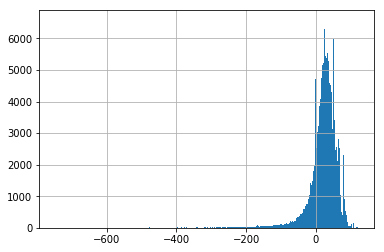

In [93]:
content_performance.readability_score.hist(bins='auto', range=(-750, 124))

#### Number of pdfs

In [94]:
content_performance.number_of_pdfs.describe()

count    417133.000000
mean          0.399429
std           2.353593
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         242.000000
Name: number_of_pdfs, dtype: float64

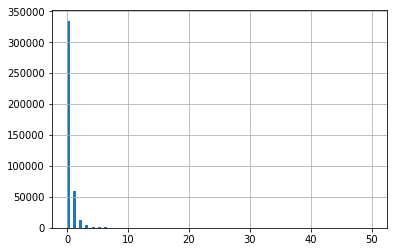

In [95]:
content_performance.number_of_pdfs.hist(bins=100, range=(0, 50))

#### Number of word files

In [96]:
content_performance.number_of_word_files.describe()

count    417133.000000
mean          0.019881
std           0.388400
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          84.000000
Name: number_of_word_files, dtype: float64

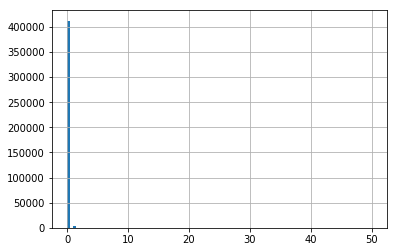

In [97]:
content_performance.number_of_word_files.hist(bins=100, range=(0, 50))

#### Composte vars

In [98]:
content_performance.spelling_grammar.describe()

count    420579.000000
mean          0.001781
std           0.009760
min           0.000000
25%           0.000101
50%           0.000603
75%           0.001798
max           1.500000
Name: spelling_grammar, dtype: float64

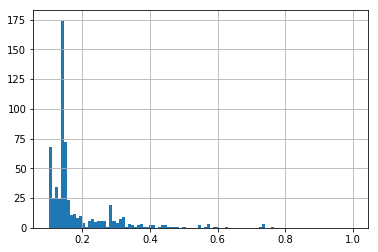

In [99]:
content_performance.spelling_grammar.hist(bins=100, range=(0.1, 1))

In [100]:
content_performance[['style']].describe()

,style
count,420579.000000
mean,0.022089
std,0.028613
min,0.000000
25%,0.011157
50%,0.016940
75%,0.022215
max,1.408788


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x483b67358>]],
      dtype=object)

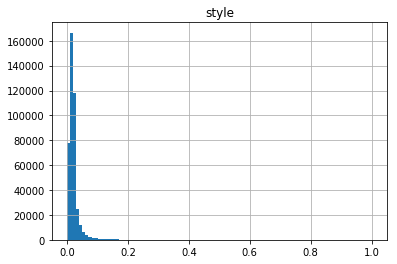

In [101]:
content_performance[['style']].hist(bins=100, range=(0, 1))

In [102]:
content_performance.errors.describe()

count    420579.000000
mean          0.004767
std           0.011683
min           0.000000
25%           0.000302
50%           0.002011
75%           0.004797
max           1.018403
Name: errors, dtype: float64

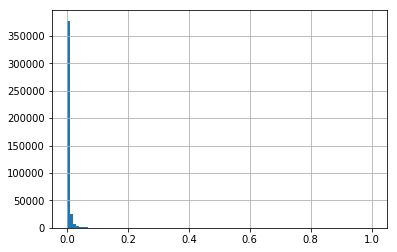

In [103]:
content_performance.errors.hist(bins=100, range=(0, 1))

## Metric over time, by doc type

In [118]:
content_performance_bytime.columns

Index(['dimensions_date_id', 'dimensions_item_id', 'pageviews',
       'unique_pageviews', 'feedex_comments', 'is_this_useful_yes',
       'is_this_useful_no', 'number_of_internal_searches', 'id', 'content_id',
       'title', 'base_path', 'description', 'created_at', 'updated_at',
       'latest', 'number_of_pdfs', 'document_type',
       'content_purpose_document_supertype', 'first_published_at',
       'public_updated_at', 'number_of_word_files', 'status',
       'readability_score', 'contractions_count', 'equality_count',
       'indefinite_article_count', 'passive_count', 'profanities_count',
       'redundant_acronyms_count', 'repeated_words_count', 'simplify_count',
       'spell_count', 'string_length', 'sentence_count', 'word_count',
       'primary_organisation_title', 'primary_organisation_content_id',
       'primary_organisation_withdrawn', 'content_hash', 'locale',
       'publishing_api_payload_version', 'count_survey_responses',
       'response_per_pageview', 'response

In [119]:
content_performance_bytime['date'] = pd.to_datetime(content_performance_bytime['dimensions_date_id'])
content_performance_bytime.index = content_performance_bytime['date']

In [120]:
content_performance_bytime.groupby(pd.Grouper(key='date', freq='D', sort=True))['pageviews'].sum()

date
2018-04-02     5557158.0
2018-04-03     8532727.0
2018-04-04     8737902.0
2018-04-05     9575892.0
2018-04-06     6139024.0
2018-04-07     4797110.0
2018-04-08     4960597.0
2018-04-09     9709028.0
2018-04-10     8480734.0
2018-04-11     8892360.0
2018-04-12     8858584.0
2018-04-13     8585662.0
2018-04-14     4535179.0
2018-04-15     5543420.0
2018-04-16    10072386.0
2018-04-17     8729985.0
2018-04-18     7345625.0
2018-04-19     7257951.0
2018-04-20     6141596.0
2018-04-21     3750411.0
2018-04-22     3843277.0
2018-04-23     8626832.0
2018-04-24     8479708.0
2018-04-25     9794103.0
2018-04-26     7604840.0
2018-04-27     8166797.0
2018-04-28     4170603.0
2018-04-29     4562665.0
2018-04-30    10538112.0
2018-05-01     7966977.0
2018-05-02     8786657.0
Freq: D, Name: pageviews, dtype: float64

In [121]:
content_performance_bytime.groupby(pd.Grouper(key='date', sort=True))['pageviews'].sum()

date
2018-04-02     5557158.0
2018-04-03     8532727.0
2018-04-04     8737902.0
2018-04-05     9575892.0
2018-04-06     6139024.0
2018-04-07     4797110.0
2018-04-08     4960597.0
2018-04-09     9709028.0
2018-04-10     8480734.0
2018-04-11     8892360.0
2018-04-12     8858584.0
2018-04-13     8585662.0
2018-04-14     4535179.0
2018-04-15     5543420.0
2018-04-16    10072386.0
2018-04-17     8729985.0
2018-04-18     7345625.0
2018-04-19     7257951.0
2018-04-20     6141596.0
2018-04-21     3750411.0
2018-04-22     3843277.0
2018-04-23     8626832.0
2018-04-24     8479708.0
2018-04-25     9794103.0
2018-04-26     7604840.0
2018-04-27     8166797.0
2018-04-28     4170603.0
2018-04-29     4562665.0
2018-04-30    10538112.0
2018-05-01     7966977.0
2018-05-02     8786657.0
Name: pageviews, dtype: float64

In [ ]:
content_performance_bytime['consolidated_format'] = content_performance_bytime['document_type'].astype('category')

In [ ]:
content_performance_bytime['consolidated_format'].cat.categories

In [ ]:
content_performance_bytime['consolidated_format'].cat.rename_categories({'Specialist alerts': 'comms', 
                                                                         'news_story': 'comms', 
                                                                         'press_release': 'comms', 
                                                                         'press_release': 'comms',
News story
Press release
Government response
World news story
Foreign lang news
Fatality notice
Speech
Statements
Case studies
, 2: 'y', 3: 'z'})

In [215]:
def plot_time_metric(df, metric, aggregation='sum'):
    if aggregation=='mean':
        grouped = df.groupby([df.index, pd.Grouper(freq='D')])[metric].mean() #resample operation for each day in datime index, sum the metric
        grouped.index = grouped.index.droplevel()
        ax = grouped.plot(figsize=(10, 10))
        ax.set_ylabel(metric)
        ax.set_xlabel('Date')
    else:
        grouped = df.groupby([df.index, pd.Grouper(freq='D')])[metric].sum() #resample operation for each day in datime index, sum the metric
        grouped.index = grouped.index.droplevel()
        ax = grouped.plot(figsize=(10, 10))
        ax.set_ylabel(metric)
        ax.set_xlabel('Date')
    

    return ax
    

In [135]:
grouped = content_performance_bytime.groupby([content_performance_bytime.index, pd.Grouper(freq='D')])['pageviews'].sum() #resample operation for each day in datime index, sum the metric
grouped.index = grouped.index.droplevel()

In [173]:
grouped

date
2018-04-02     5557158.0
2018-04-03     8532727.0
2018-04-04     8737902.0
2018-04-05     9575892.0
2018-04-06     6139024.0
2018-04-07     4797110.0
2018-04-08     4960597.0
2018-04-09     9709028.0
2018-04-10     8480734.0
2018-04-11     8892360.0
2018-04-12     8858584.0
2018-04-13     8585662.0
2018-04-14     4535179.0
2018-04-15     5543420.0
2018-04-16    10072386.0
2018-04-17     8729985.0
2018-04-18     7345625.0
2018-04-19     7257951.0
2018-04-20     6141596.0
2018-04-21     3750411.0
2018-04-22     3843277.0
2018-04-23     8626832.0
2018-04-24     8479708.0
2018-04-25     9794103.0
2018-04-26     7604840.0
2018-04-27     8166797.0
2018-04-28     4170603.0
2018-04-29     4562665.0
2018-04-30    10538112.0
2018-05-01     7966977.0
2018-05-02     8786657.0
Freq: D, Name: pageviews, dtype: float64

In [197]:
mdates.date2num(grouped.index)

array([736786., 736787., 736788., 736789., 736790., 736791., 736792.,
       736793., 736794., 736795., 736796., 736797., 736798., 736799.,
       736800., 736801., 736802., 736803., 736804., 736805., 736806.,
       736807., 736808., 736809., 736810., 736811., 736812., 736813.,
       736814., 736815., 736816.])

# WEEKDAY STILL WRONG!
1st Apr=sunday


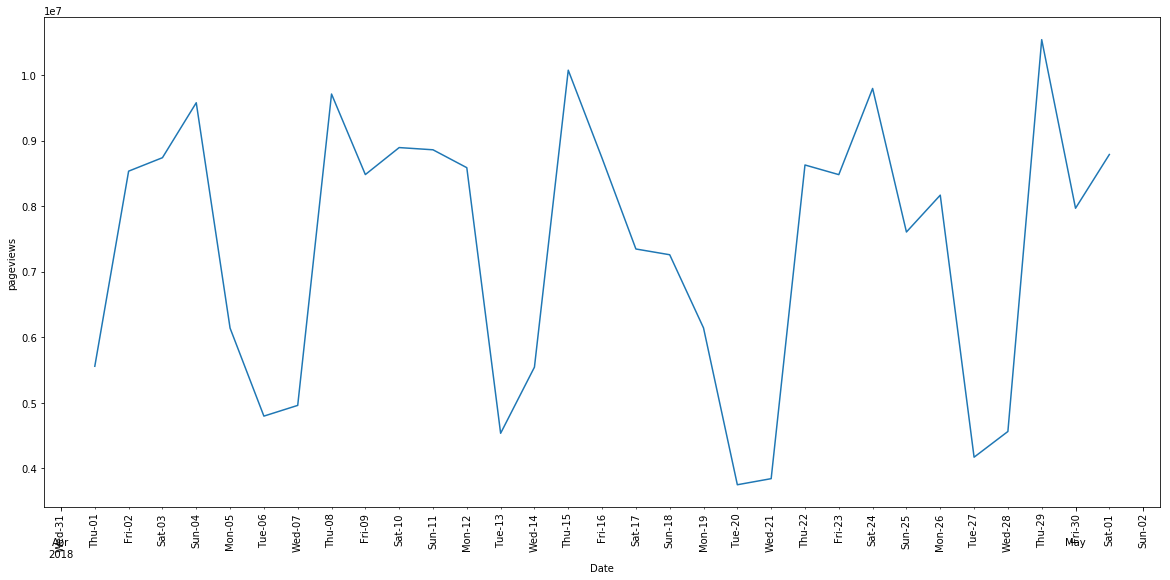

In [194]:
import matplotlib.dates as mdates
fig, ax = plt.subplots()
#days = mdates.DayLocator()
# months = mdates.MonthLocator()  # every month

dfmt = mdates.DateFormatter('%a-%d')

    
ax = grouped.plot(figsize=(20, 10))
ax.set_ylabel('pageviews')
ax.set_xlabel('Date')
#ax.xaxis.set_major_locator(days)
ax.xaxis.set_minor_formatter(dfmt)
fig.autofmt_xdate(rotation=90, ha='center', which='minor')

In [139]:
mean_useful = content_performance_bytime.groupby([content_performance_bytime.index, pd.Grouper(freq='D')])['useful_per_responses'].mean() #resample operation for each day in datime index, meanof the metric
mean_useful.index = mean_useful.index.droplevel()

In [141]:
days

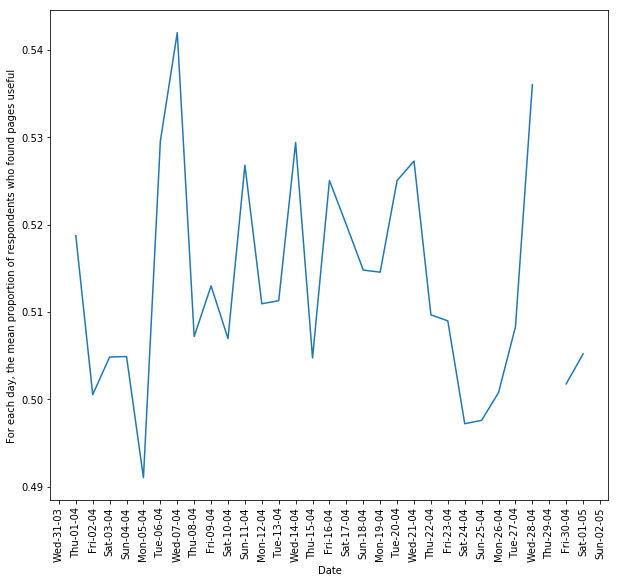

In [213]:
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

fig, ax = plt.subplots()
days = mdates.DayLocator()
dfmt = mdates.DateFormatter('%a-%d-%m')
# months = mdates.MonthLocator()  # every month
# weekdays = mdates.WeekdayLocator(byweekday=MO, Sa)
weekday_fmt = mdates.DateFormatter('%a')

    
ax = mean_useful.plot(figsize=(10, 10))
ax.set_ylabel('For each day, the mean proportion of respondents who found pages useful')
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(dfmt)
ax.xaxis.set_minor_locator(weekdays)
#ax.xaxis.set_minor_formatter(weekday_fmt)
fig.autofmt_xdate(rotation=90, ha='center')


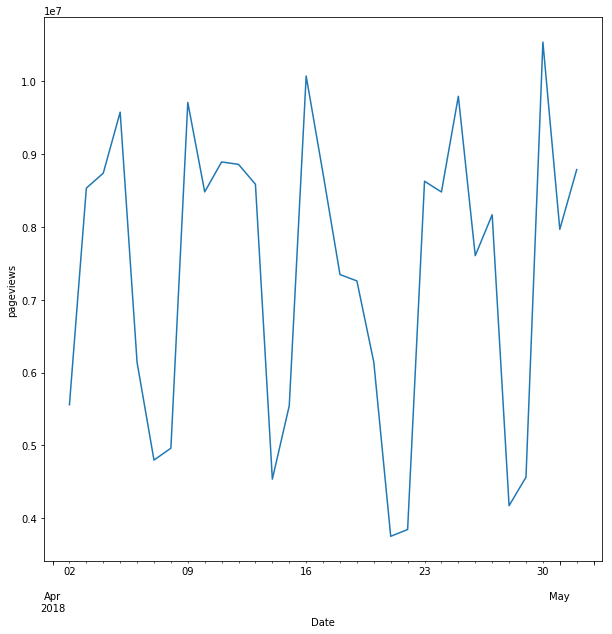

In [217]:
plot_time_metric(content_performance_bytime, 'pageviews')

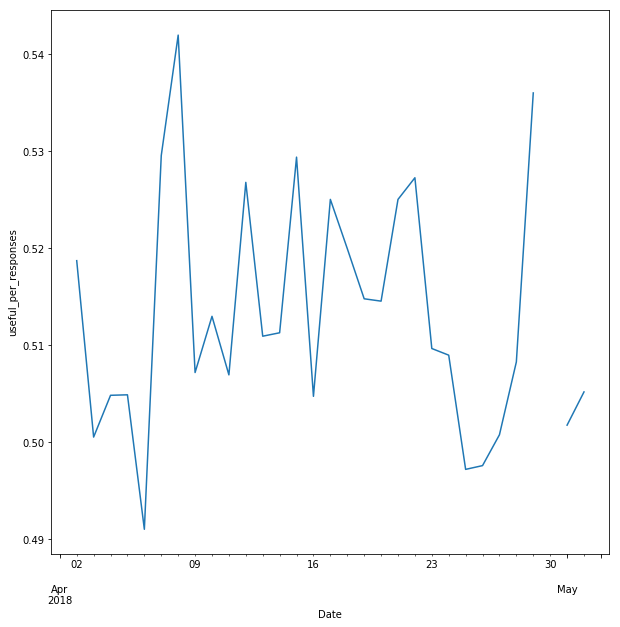

In [216]:
plot_time_metric(content_performance_bytime, 'useful_per_responses', aggregation='mean')

In [218]:
grouped_unique_pageviews = content_performance_bytime.groupby([content_performance_bytime.index, pd.Grouper(freq='D')])['unique_pageviews'].sum() #resample operation for each day in datime index, sum the metric
grouped_unique_pageviews.index = grouped_unique_pageviews.index.droplevel()

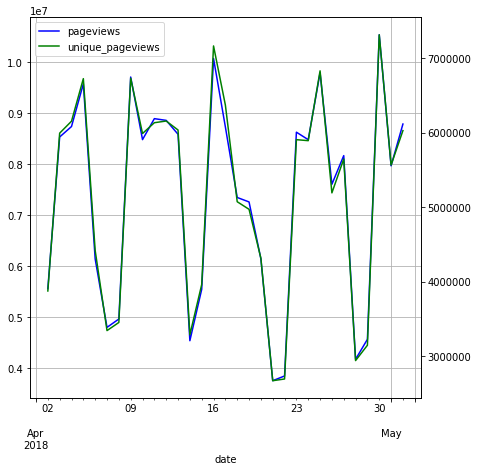

In [224]:
plt.figure(figsize=(7,7))
plt.xlabel('Date')

ax1 = grouped.plot(color='blue', label='pageviews')
ax2 = grouped_unique_pageviews.plot(color='green', grid=True, secondary_y=True, label='unique_pageviews')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

In [ ]:
plot_time_metric(content_performance_bytime, 'unique_pageviews')

In [ ]:
plot_time_metric(content_performance_bytime, 'feedex_comments')

In [ ]:
plot_time_metric(content_performance_bytime, 'useful_per_responses')

In [ ]:
content_performance_bytime.columns

In [ ]:
plot_time_metric(content_performance_bytime, 'count_survey_response')

### trying to get weekday onto plot. 
Aborted for now. think ax.table might work

In [ ]:
grouped = content_performance_bytime.groupby([content_performance_bytime.index, pd.Grouper(freq='D')])['pageviews'].sum()
grouped.index = grouped.index.droplevel()


In [ ]:
grouped = grouped.to_frame()

In [ ]:
grouped['day'] = grouped.index.weekday_name

In [ ]:
grouped

In [ ]:
ax = grouped.plot()
ax.set_ylabel('Pageviews (100M)')
ax.set_xlabel('Date')
plt.show()

In [ ]:
list(zip(grouped.index, grouped.index.weekday_name))

That's a bit odd. Assumed 12/13th would be weekend but they're Thurs/Friday. 

In [ ]:
grouped.index.weekday_name

### Stratify by categorical variables

In [ ]:
def plot_time_metric_byvar(df, metric, byvar):
    grouped = df.groupby([byvar, pd.Grouper(freq='D')])[metric].sum()
    by_day = grouped.unstack(byvar, fill_value=0)
    top = by_day.iloc[:, by_day.columns.isin(by_day.min().sort_values(ascending=False)[:10].index)]
    bottom = by_day.iloc[:, by_day.columns.isin(by_day.min().sort_values()[:10].index)]
    
    ax = top.plot()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel(metric)
    ax.set_xlabel('Date')
    ax.set_title('Top 10 {}s for {}'.format(byvar, metric))
    
    ay = bottom.plot()
    ay.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ay.set_ylabel(metric)
    ay.set_xlabel('Date')
    ay.set_title('Bottom 10 {}s for {}'.format(byvar, metric))

    return ax, ay
    

In [ ]:
plot_time_metric_byvar(df=content_performance_bytime, metric='pageviews', byvar='document_type')

In [ ]:
plot_time_metric_byvar(df=content_performance_bytime, metric='unique_pageviews', byvar='document_type')

In [ ]:
plot_time_metric_byvar(df=content_performance_bytime, metric='feedex_comments', byvar='document_type')

Document types with no page views in date range

In [ ]:
#over the whole month (includes entire data range) total number of page views 

x = content_performance_bytime.groupby(['document_type', pd.Grouper(freq='M')])['pageviews'].sum()

In [ ]:
#which documen types had no page views
x[x==0]

In [ ]:
plot_time_metric_byvar(df=content_performance_bytime, metric='pageviews', byvar='primary_organisation_title')

In [ ]:
plot_time_metric_byvar(df=content_performance_bytime, metric='unique_pageviews', byvar='primary_organisation_title')

In [ ]:
plot_time_metric_byvar(df=content_performance_bytime, metric='feedex_comments', byvar='primary_organisation_title')

In [ ]:
plot_time_metric_byvar(df=content_performance_bytime, metric='pageviews', byvar='content_purpose_document_supertype')

In [ ]:
plot_time_metric_byvar(df=content_performance_bytime, metric='unique_pageviews', byvar='content_purpose_document_supertype')

In [ ]:
plot_time_metric_byvar(df=content_performance_bytime, metric='feedex_comments', byvar='content_purpose_document_supertype')

### correlation

In [ ]:
plt.matshow(content_performance_bytime.corr())

# Intrinsic content performance metrics
Explore those metrics generated by characteristics of the content itself and their correlation with metrics relating to user interaction with content.

<span style="color:red">There are multiple ids per content_id reflecting a change to the content e.g., re-written.</span>

**Need to think about left/right censoring for these items when considering date ranges**

In [ ]:
content_performance.columns

In [ ]:
def scatter_byvar(df, x, y, byvar, log=True):
    groups = df.groupby(byvar)

    # Plot
    cmap = plt.get_cmap('jet')
    colors = cmap(np.linspace(0, 1.0, len(groups)))

    fig, ax = plt.subplots()
    ax.set_prop_cycle(cycler('color', colors))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    
    ax.set_xlabel(x)
    ax.set_title('{} and {} by {}'.format(x, y, byvar))
    
    if log:
        for name, group in groups:
            ax.plot(group[x], np.log(group[y]), marker='o', linestyle='',  label=name, alpha=0.5)
            ax.set_ylabel('log({})'.format(y))
    else:
        for name, group in groups:
            ax.plot(group[x], group[y], marker='o', linestyle='',  label=name, alpha=0.5 )
            ax.set_ylabel(y)
            
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    return ax

#### string length

In [ ]:
content_performance.string_length.describe()

In [ ]:
content_performance[content_performance['string_length']==0].shape

In [ ]:
print('{} out of {} content items ({}%) have a recorded string_length of 0'.format(
    content_performance[content_performance['string_length']==0].shape[0], 
    content_performance.content_id.nunique(),
    round(content_performance[content_performance['string_length']==0].shape[0]/content_performance.content_id.nunique()*100, 2)))

In [ ]:
content_performance.string_length.hist(bins='auto', range=(0, 7000))

In [ ]:
scatter_byvar(df=content_performance, x='string_length', y='unique_pageviews', byvar='content_purpose_document_supertype')

#### readability score
"Check readability"?!

In [ ]:
content_performance.readability_score.hist(bins='auto', range=(-750, 124))

In [ ]:
content_performance.readability_score.describe()

In [ ]:
scatter_byvar(df=content_performance, x='readability_score', y='unique_pageviews', byvar='content_purpose_document_supertype')

#### Number of pdfs

In [ ]:
content_performance.number_of_pdfs.describe()

In [ ]:
content_performance.number_of_pdfs.hist(bins=100, range=(0, 50))

In [ ]:
scatter_byvar(df=content_performance, x='number_of_pdfs', y='unique_pageviews', byvar='content_purpose_document_supertype')

#### Number of word files

In [ ]:
content_performance.number_of_word_files.describe()

In [ ]:
content_performance.number_of_word_files.hist(bins=100, range=(0, 50))

In [ ]:
scatter_byvar(df=content_performance, x='number_of_word_files', y='unique_pageviews', byvar='content_purpose_document_supertype')

#### retractions
Check apostrophe use in contractions. 
This should feed into a general ‘spelling/grammar errors’ metric.

In [ ]:
scatter_byvar(df=content_performance, x='contractions_count', y='unique_pageviews', byvar='content_purpose_document_supertype')

#### retext-equality 
- Warn about possible insensitive, inconsiderate language. This has some interesting changes (‘commit suicide’ to ‘die by suicide’, for example). Not sure how publishers would respond to this if they had lots of changes, but inclusive language should be important for us.

In [ ]:
scatter_byvar(df=content_performance, x='equality_count', y='unique_pageviews', byvar='content_purpose_document_supertype')

#### retext-indefinite-article
Check if indefinite articles (a, an) are used correctly. This should feed into a general ‘spelling/grammar errors’ metric.


In [ ]:
scatter_byvar(df=content_performance, x='indefinite_article_count', y='unique_pageviews', byvar='content_purpose_document_supertype')

In [ ]:
#scatter_byvar(df=content_performance, x='readability_score', y='unique_pageviews', byvar='document_type')

In [ ]:
scatter_byvar(df=content_performance, x='readability_score', y='unique_pageviews', byvar='content_purpose_document_supertype')

## metric by content age

In [225]:
content_performance.columns

Index(['pageviews', 'unique_pageviews', 'feedex_comments',
       'is_this_useful_yes', 'is_this_useful_no',
       'number_of_internal_searches', 'id', 'content_id', 'title', 'base_path',
       'description', 'created_at', 'updated_at', 'latest', 'raw_json',
       'number_of_pdfs', 'document_type', 'content_purpose_document_supertype',
       'first_published_at', 'public_updated_at', 'number_of_word_files',
       'status', 'readability_score', 'contractions_count', 'equality_count',
       'indefinite_article_count', 'passive_count', 'profanities_count',
       'redundant_acronyms_count', 'repeated_words_count', 'simplify_count',
       'spell_count', 'string_length', 'sentence_count', 'word_count',
       'primary_organisation_title', 'primary_organisation_content_id',
       'primary_organisation_withdrawn', 'content_hash', 'locale',
       'publishing_api_payload_version', '_merge', 'count_survey_responses',
       'response_per_pageview', 'response_per_unique_pageview',
      

In [226]:
first_published = content_performance[['first_published_at', 'pageviews', 'unique_pageviews', 'document_type', 'content_purpose_document_supertype']].copy()

In [227]:
first_published['first_published_at'] = pd.to_datetime(first_published['first_published_at']).copy()
first_published.index = first_published['first_published_at']

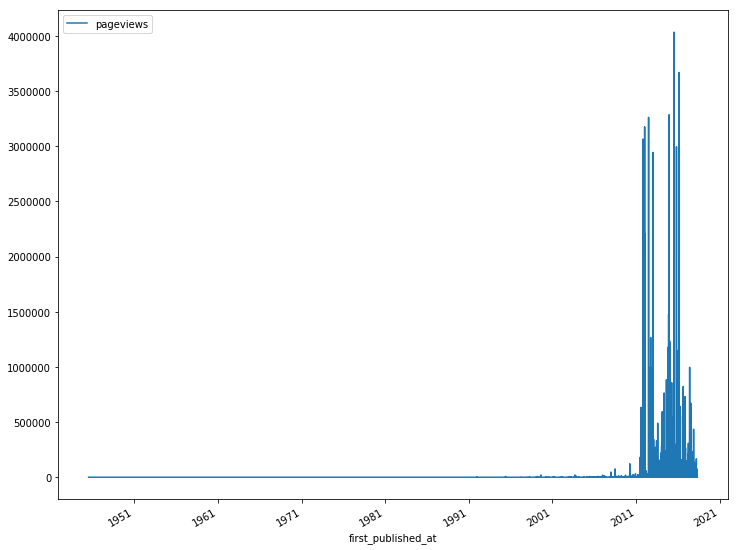

In [251]:
first_published.plot(x='first_published_at', y='pageviews', figsize=(12, 10))

Old items are generally not being viewed

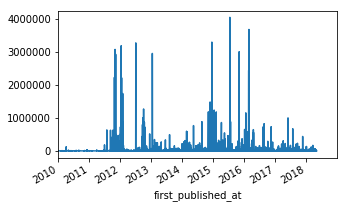

In [312]:
ax = first_published.plot(x='first_published_at', y='pageviews', figsize=(5, 3))
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2018-12-31'))
ax.legend_.remove()

(0, 1000)

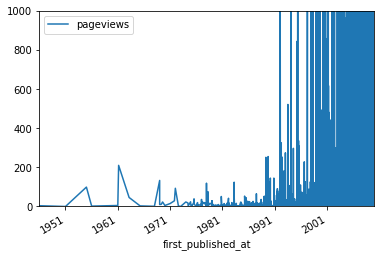

In [230]:
ay = first_published.plot(x='first_published_at', y='pageviews')
ay.set_xlim(pd.Timestamp('1945-12-31'), pd.Timestamp('2009-12-31'))
ay.set_ylim(0, 1000)

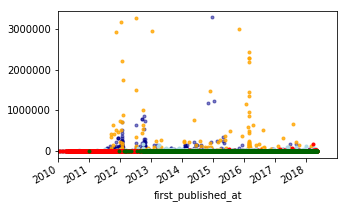

In [308]:
fig, ax = plt.subplots(figsize=(5, 3))

first_published[first_published['document_type']=='guide'].plot(x='first_published_at', y='pageviews', color='DarkBlue', label='guide', style=".", ax=ax, alpha=0.5)
first_published[first_published['document_type']=='transaction'].plot(x='first_published_at', y='pageviews', color='Orange', label='transaction', style=".", ax=ax, alpha=0.8)

first_published[first_published['document_type']=='guidance'].plot(x='first_published_at', y='pageviews', color='LightBlue', label='guidance', style=".", ax=ax)
first_published[first_published['document_type']=='news_story'].plot(x='first_published_at', y='pageviews', color='Red', label='news_story', style=".", ax=ax)
first_published[first_published['document_type']=='world_news_story'].plot(x='first_published_at', y='pageviews', color='DarkGreen', label='world_news_story', style=".", ax=ax)
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2018-12-31'))
ax.legend_.remove()

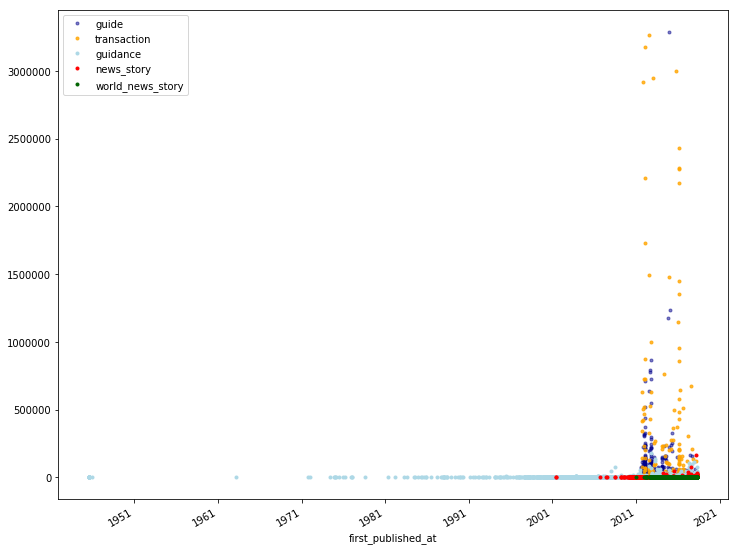

In [309]:
fig, ax = plt.subplots(figsize=(12, 10))

first_published[first_published['document_type']=='guide'].plot(x='first_published_at', y='pageviews', color='DarkBlue', label='guide', style=".", ax=ax, alpha=0.5)
first_published[first_published['document_type']=='transaction'].plot(x='first_published_at', y='pageviews', color='Orange', label='transaction', style=".", ax=ax, alpha=0.8)

first_published[first_published['document_type']=='guidance'].plot(x='first_published_at', y='pageviews', color='LightBlue', label='guidance', style=".", ax=ax)
first_published[first_published['document_type']=='news_story'].plot(x='first_published_at', y='pageviews', color='Red', label='news_story', style=".", ax=ax)
first_published[first_published['document_type']=='world_news_story'].plot(x='first_published_at', y='pageviews', color='DarkGreen', label='world_news_story', style=".", ax=ax)

plt.legend()

In [252]:
groups = first_published.groupby('content_purpose_document_supertype')

In [253]:
first_published.groupby('content_purpose_document_supertype').describe()

pageviews                               \
                                       count          mean            std   
content_purpose_document_supertype                                          
contacts                               141.0  20298.666667   62949.952084   
corporate-info                       12597.0    126.564023    1322.096463   
data                                 35390.0     40.210483     365.364361   
decisions                            53320.0      8.595349      97.849014   
engagement-activities                 6477.0    104.659101     780.350390   
grants-and-funding                    1413.0     77.561925     234.918671   
guidance                            125145.0    693.789372   14393.328322   
navigation                            9349.0   3464.688202   56172.474804   
news                                 83349.0     45.285558     919.536227   
organising-entities                   5915.0   2225.005241   52172.442770   
other                                32277.0     54.882765    5208.289075   
reports                              28222.0     38.558642     238.762534   
resources                             1781.0    198.699607    1215.995668   
service-manual                         183.0    685.081967    1420.064102   
speeches-and-statements               9673.0     28.513284     225.550223   
transactions                          6619.0  12783.835474  134079.149331   
updates-and-alerts                    5282.0     37.230973     323.000124   

                                                                           \
                                    min    25%     50%     75%        max   
content_purpose_document_supertype                                          
contacts                            0.0  446.0  1628.0  8559.0   537710.0   
corporate-info                      0.0    0.0     2.0    13.0    84008.0   
data                                0.0    0.0     1.0     8.0    25762.0   
decisions                           0.0    0.0     0.0     4.0    15167.0   
engagement-activities               0.0    1.0     5.0    16.0    39806.0   
grants-and-funding                  0.0    0.0     5.0    61.0     4507.0   
guidance                            0.0    2.0    12.0    58.0  3286294.0   
navigation                          0.0    0.0    17.0   289.0  3668934.0   
news                                0.0    0.0     1.0     6.0   166596.0   
organising-entities                 0.0   11.0    44.0   174.0  3065278.0   
other                               0.0    0.0     0.0     0.0   822396.0   
reports                             0.0    1.0     4.0    15.0    13366.0   
resources                           0.0    5.0    15.0    68.0    30573.0   
service-manual                      8.0  157.0   314.0   569.0    11725.0   
speeches-and-statements             0.0    0.0     2.0     9.0    15874.0   
transactions                        0.0    9.0    61.0   453.5  4035051.0   
updates-and-alerts                  0.0    0.0     2.0    13.0    15610.0   

                                   unique_pageviews                \
                                              count          mean   
content_purpose_document_supertype                                  
contacts                                      141.0  14239.567376   
corporate-info                              12597.0    101.651346   
data                                        35390.0     30.534388   
decisions                                   53320.0      6.576294   
engagement-activities                        6477.0     79.864752   
grants-and-funding                           1413.0     64.534324   
guidance                                   125145.0    538.325902   
navigation                                   9349.0   2533.241951   
news                                        83349.0     39.974073   
organising-entities                          5915.0   1749.482333   
other                                       32277.0     

In [254]:
first_published.groupby('content_purpose_document_supertype').groups['other'].min()

Timestamp('2002-02-08 00:00:00')

In [255]:
for group in groups:
    print(min(group[1].first_published_at))

2014-12-04 09:38:33
1951-01-01 00:00:00
1981-07-31 23:00:00
1955-01-01 00:00:00
1994-03-31 23:01:00
2014-08-26 13:47:51
1945-07-18 10:11:00
1992-01-01 00:00:00
1995-07-20 00:00:00
2011-10-11 16:11:43
2002-02-08 00:00:00
1969-01-01 00:00:00
2005-05-31 23:00:00
2016-02-16 17:25:28
2008-06-24 00:00:00
1991-07-04 11:00:00
2002-04-09 01:00:00


In [256]:
first_published.index.min()

Timestamp('1945-07-18 10:11:00')

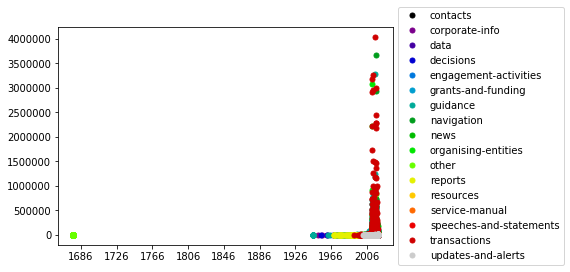

In [257]:
# Plot
cmap = plt.get_cmap('nipy_spectral')
colors = cmap(np.linspace(0, 1.0, len(groups)))

fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', colors))

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    
    ax.plot(group['first_published_at'], group['pageviews'], marker='o', linestyle='', ms=5, label=name)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.show()

ALERT! Cannot understand why this 1686 data is coming from. It is not showing up when I print the timestamps. how is it getting into plot ?



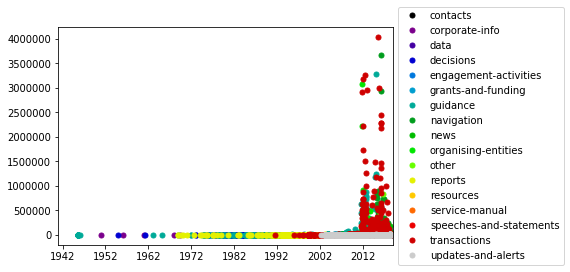

In [258]:
# Plot
cmap = plt.get_cmap('nipy_spectral')
colors = cmap(np.linspace(0, 1.0, len(groups)))

fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', colors))

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    
    ax.plot(group['first_published_at'], group['pageviews'], marker='o', linestyle='', ms=5, label=name)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim(pd.Timestamp('1940-12-31'), pd.Timestamp('2018-12-31'))

plt.show()

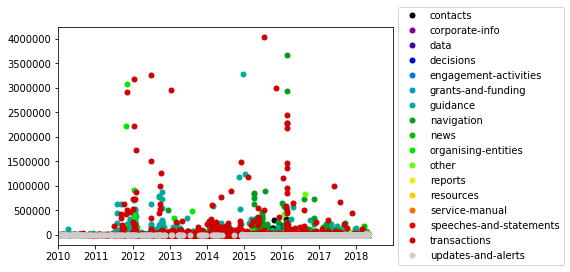

In [259]:
# Plot
cmap = plt.get_cmap('nipy_spectral')
colors = cmap(np.linspace(0, 1.0, len(groups)))

fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', colors))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    
    ax.plot(group['first_published_at'], group['pageviews'], marker='o', linestyle='', ms=5, label=name)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim(pd.Timestamp('2009-12-31'), pd.Timestamp('2018-12-31'))

plt.show()

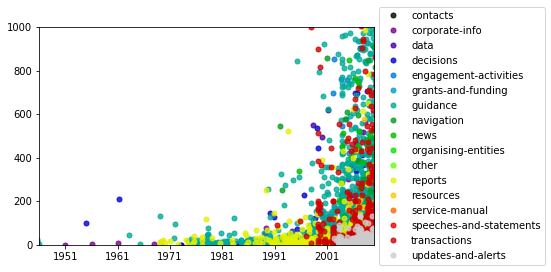

In [260]:
# Plot
cmap = plt.get_cmap('nipy_spectral')
colors = cmap(np.linspace(0, 1.0, len(groups)))

fig, ax = plt.subplots()
ax.set_prop_cycle(cycler('color', colors))
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    
    ax.plot(group['first_published_at'], group['pageviews'], marker='o', linestyle='', ms=5, label=name, alpha=0.8)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim(pd.Timestamp('1945-12-31'), pd.Timestamp('2009-12-31'))
ax.set_ylim(0, 1000)
plt.show()

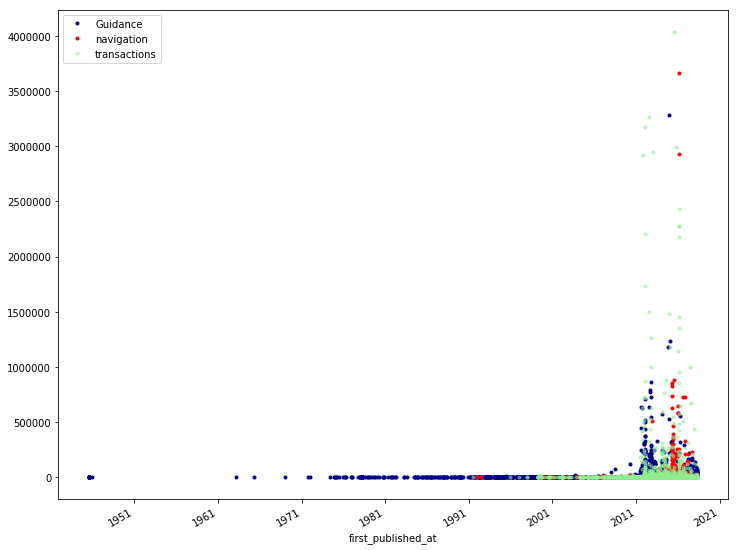

In [289]:
fig, ax = plt.subplots(figsize=(12, 10))

first_published[first_published['content_purpose_document_supertype']=='guidance'].plot(x='first_published_at', y='pageviews', color='DarkBlue', label='Guidance', style=".", ax=ax)
first_published[first_published['content_purpose_document_supertype']=='navigation'].plot(x='first_published_at', y='pageviews', color='Red', label='navigation', style=".", ax=ax)
first_published[first_published['content_purpose_document_supertype']=='transactions'].plot(x='first_published_at', y='pageviews', color='LightGreen', label='transactions', style=".", alpha=0.5, ax=ax)

plt.legend()

### pageviews by reading age

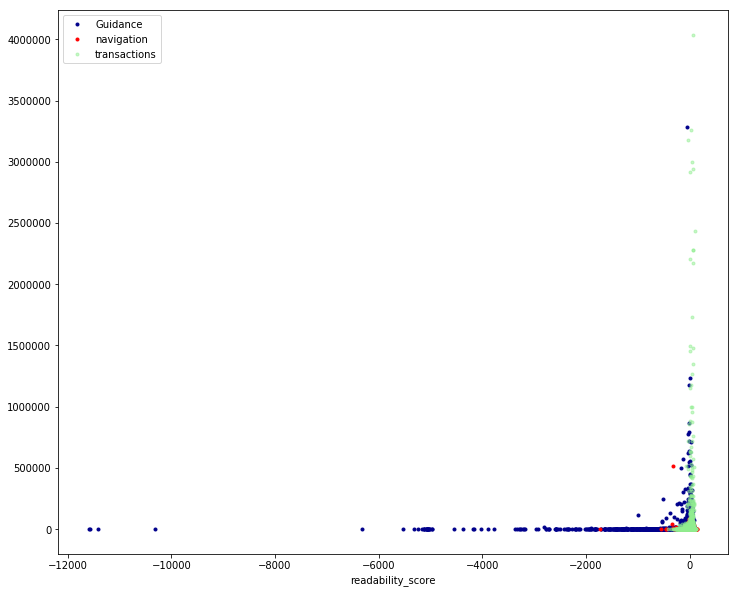

In [286]:
fig, ax = plt.subplots(figsize=(12, 10))

scatter1 = content_performance[content_performance['content_purpose_document_supertype']=='guidance'].plot(x='readability_score', y='pageviews', color='DarkBlue', label='Guidance', style=".", ax=ax)
scatter2 = content_performance[content_performance['content_purpose_document_supertype']=='navigation'].plot(x='readability_score', y='pageviews', color='Red', label='navigation', style=".", ax=ax)
scatter3 = content_performance[content_performance['content_purpose_document_supertype']=='transactions'].plot(x='readability_score', y='pageviews', color='LightGreen', label='transactions', style=".", alpha=0.5, ax=ax)

plt.legend()

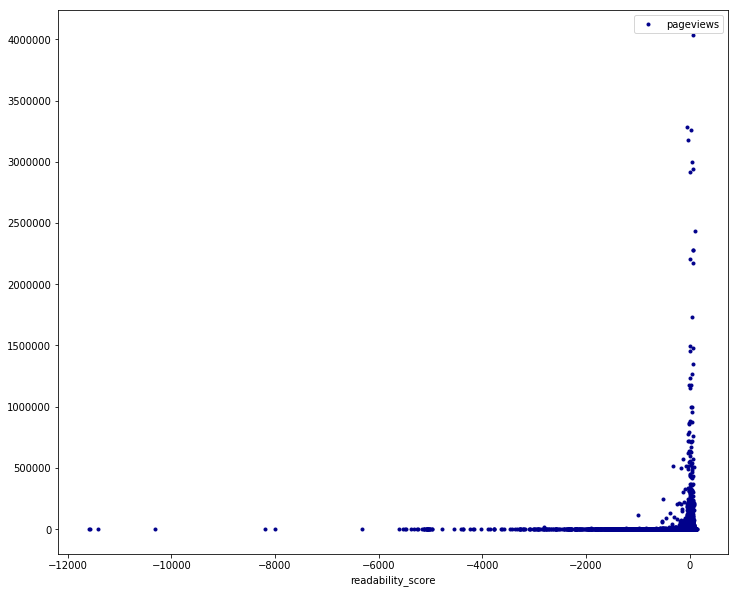

In [266]:
content_performance.plot(x='readability_score', y='pageviews', color='DarkBlue', style=".", figsize=(12, 10))



In [273]:
content_performance.readability_score.describe()

count    358695.000000
mean         14.954658
std         109.860236
min      -11595.000000
25%           7.000000
50%          26.000000
75%          43.000000
max         147.000000
Name: readability_score, dtype: float64

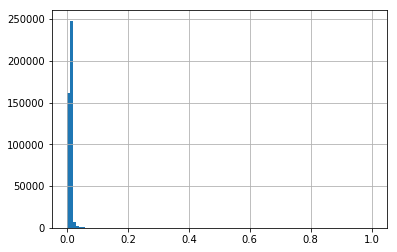

In [272]:
content_performance.readability_score_scaled.hist(bins=100)

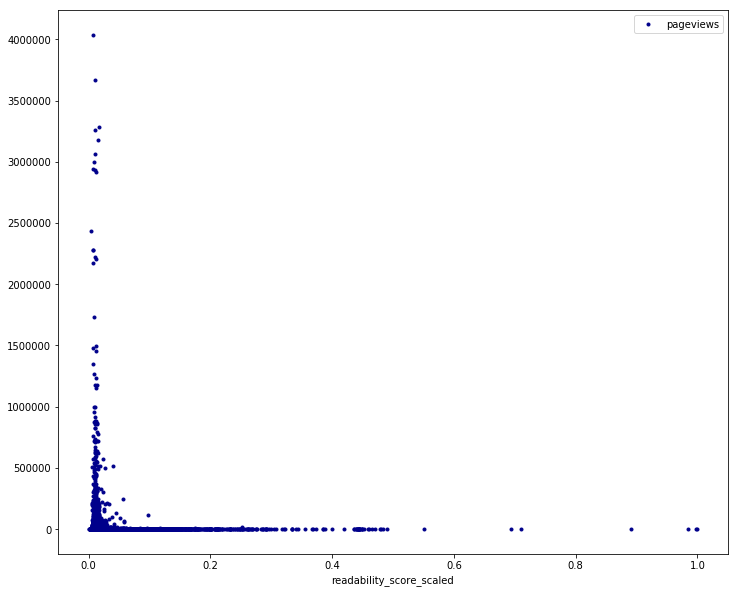

In [267]:
content_performance.plot(x='readability_score_scaled', y='pageviews', color='DarkBlue', style=".", figsize=(12, 10))



### pageviews by spelling/grammar

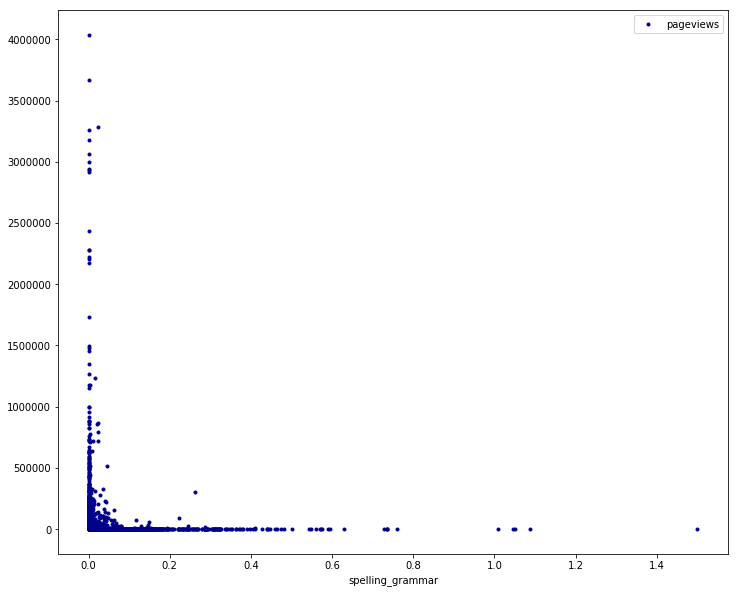

In [274]:
content_performance.plot(x='spelling_grammar', y='pageviews', color='DarkBlue', style=".", figsize=(12, 10))



### pageviews by usefulness rating

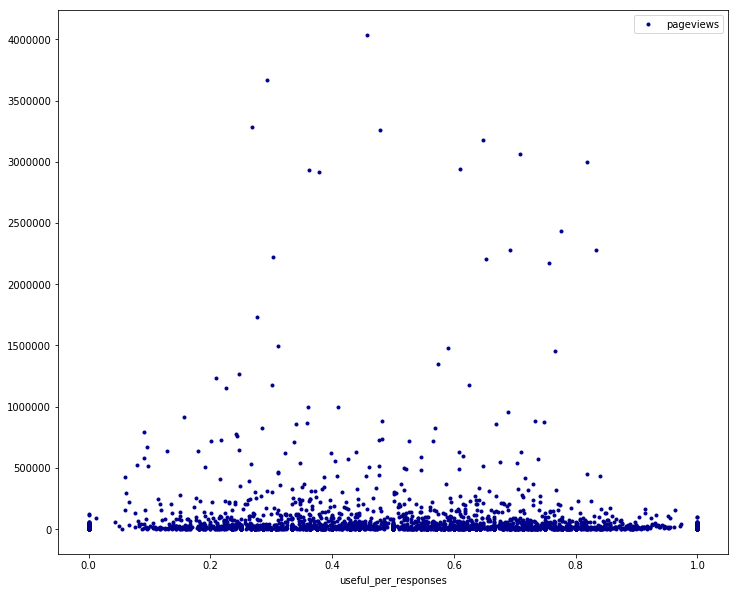

In [275]:
content_performance.plot(x='useful_per_responses', y='pageviews', color='DarkBlue', style=".", figsize=(12, 10))



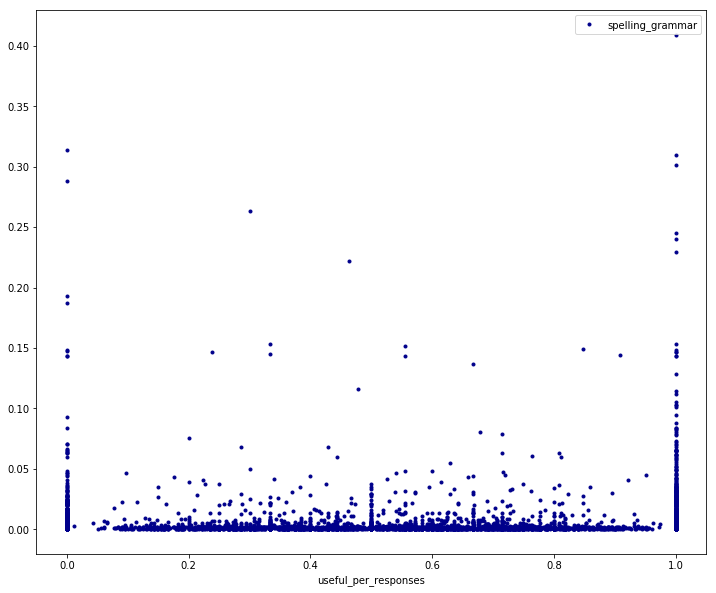

In [276]:
content_performance.plot(x='useful_per_responses', y='spelling_grammar', color='DarkBlue', style=".", figsize=(12, 10))



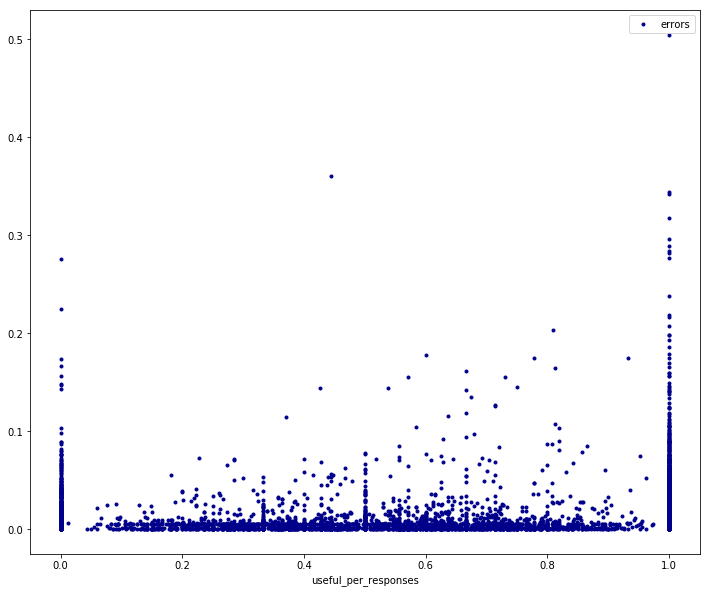

In [277]:
content_performance.plot(x='useful_per_responses', y='errors', color='DarkBlue', style=".", figsize=(12, 10))



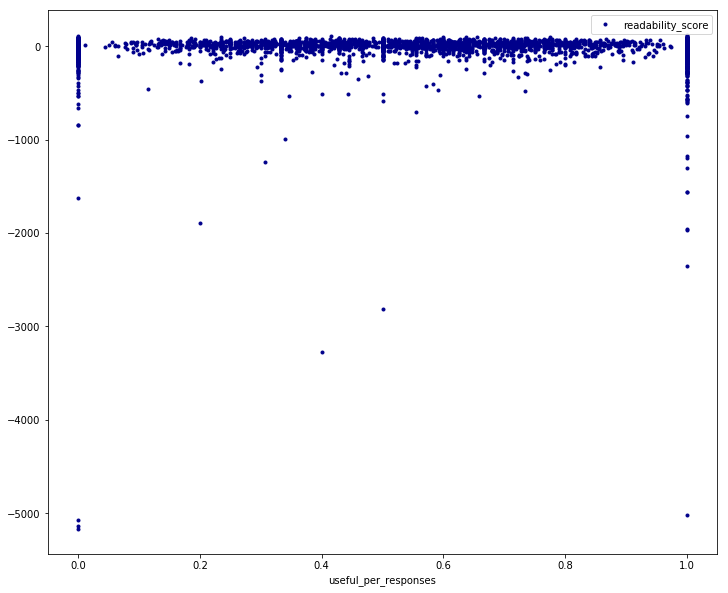

In [278]:
content_performance.plot(x='useful_per_responses', y='readability_score', color='DarkBlue', style=".", figsize=(12, 10))

